In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Collecting data from different datasets

In [3]:
# Load Sleep data from the .xpt file and setting 'SEQN' as the index for easier referencing
sleep = pd.read_sas('P_SLQ.xpt').set_index('SEQN')

# Rename columns for better readability and understanding of the data
sleep = sleep.rename(columns={'SLQ300': 'Bedtime_weekdays',      # Usual sleep time on weekdays or workdays
                              'SLQ310': 'Wake_time_weekdays',    # Usual wake time on weekdays or workdays
                               'SLD012': 'Sleep_hrs_weekdays',    # Sleep hours - weekdays or workdays
                              'SLQ320': 'Bedtime_weekends',      # Usual bedtime on weekends
                              'SLQ330': 'Wake_time_weekends',    # Usual wake time on weekends
                              'SLD013': 'Sleep_hrs_weekends',    # Sleep hours - weekends
                              'SLQ040': 'Stop_breathing',        # How often do you snort or stop breathing
                              'SLQ030': 'Snore',                 # How often do you snore?
                              'SLQ050': 'Sleeping_problems',     # Ever told doctor had trouble sleeping?
                              'SLQ120': 'Sleepy_during_day'})    # How often feel overly sleepy during day?

# Convert columns with byte strings to normal strings.
time_cols = ['Bedtime_weekdays', 'Wake_time_weekdays', 'Bedtime_weekends', 'Wake_time_weekends'] #Columns with byte strings
for col in time_cols:
    sleep[col] = sleep[col].str.decode('utf-8')

# Replace '77777' and '99999' with NaN (because they represent 'refused' or 'don't know').
sleep[time_cols] = sleep[time_cols].replace({'77777': np.nan, '99999': np.nan, '': np.nan})

# Create columns with bedtime and wake-up time in hours (float) using datetime formatting for calculation
for col in time_cols:
    temp = pd.to_datetime(sleep[col], format='%H:%M', errors='coerce')
    sleep[f'{col}_hrs'] = temp.dt.hour +  temp.dt.minute / 60

# Drop missing values for Bedtime/Wake_time and Sleep_hrs 
# The analysis has shown that there is no overlap where we can recover (calculate) any missing values
critical_cols = ['Bedtime_weekdays_hrs', 'Wake_time_weekdays_hrs',
                 'Bedtime_weekends_hrs', 'Wake_time_weekends_hrs',
                 'Sleep_hrs_weekdays', 'Sleep_hrs_weekends'] 

# Drop rows with any missing values in critical columns
size_before = len(sleep)
print('Shape before dropping rows:', sleep.shape)
sleep.dropna(subset=critical_cols, inplace=True)
print(f'Retained rows: {len(sleep) / size_before:.2f}')

# Create circular encoded time columns for correct distance calculations (for example, 23:00 and 1:00)
time_cols_hrs = [f'{col}_hrs' for col in time_cols]

for col in time_cols_hrs:
    sleep[f'{col}_sin'] = np.sin(2 * np.pi * sleep[col] / 24)
    sleep[f'{col}_cos'] = np.cos(2 * np.pi * sleep[col] / 24)

# Create column to calculate difference between weekday/weekend bedtimes
sleep['Social_Jetlag'] = np.sqrt(
    (sleep.Bedtime_weekends_hrs_sin - sleep.Bedtime_weekdays_hrs_sin) ** 2 + (sleep.Bedtime_weekends_hrs_cos - sleep.Bedtime_weekdays_hrs_cos) ** 2
)

# Convert 'Social_Jetlag' to hours for better interpretation
sleep['Jetlag_hrs'] = 2 * np.arcsin(sleep.Social_Jetlag / 2) * 24 /(2 * np.pi)
   
# Choose categorical columns
cat_cols = ['Stop_breathing', 'Snore', 'Sleeping_problems', 'Sleepy_during_day']

# Codes
# 'Stop_breathing': 0 - Never, 1 - Rarely (1-2 nights a week), 2 - Occasionally (3-4 nights a week), 
#                   3 - Frequently (5 or more nights a week), 7 - Refused, 9 - Don't know
# 'Snore': 0 - Never, 1 - Rarely (1-2 nights a week), 2 - Occasionally (3-4 nights a week), 
#          3 - Frequently (5 or more nights a week), 7 - Refused, 9 - Don't know
# 'Sleeping_problems': 1 - Yes, 2 - No, 7 - Refused, 9 - Don't know
# 'Sleepy_during_day': 0 - Never, 1 - Rarely (1 time a month), 2 - Sometimes (2-4 times a month),
#                      3 - Often (5-15 times a month), 4 - Almost always (16-30 times a month),
#                      7 - Refused, 9 - Don't know


# Replace very small nuber (5.397605e-79) with 0
# Replace '7' and '9' with NaN
for col in cat_cols:
    sleep[col] = sleep[col].apply(lambda x: 0 if isinstance(x, float) and abs(x - 5.397605e-79) < 1e-80 else x)
    sleep[col] = sleep[col].replace([7, 9], np.nan)

# Replace 2 which indicates 'No' by 0 in 'Sleeping_problem' column
sleep.Sleeping_problems = sleep.Sleeping_problems.replace(2, 0)

# Create indicators for missing values in categorical columns
# Impute missing values in categorical columns with mode
for col in cat_cols:
    sleep[f'{col}_missing'] = sleep[col].isnull().astype(int)
    sleep[col] = sleep[col].fillna(sleep[col].mode()[0])

# Sleep Apnea Risk score
sleep['Sleep_Apnea_risk'] = (sleep.Snore == 3).astype(int) + (sleep.Stop_breathing == 3).astype(int)

# Sleep Health Index score(higher -> better)
sleep['Sleep_health'] = (sleep.Sleep_hrs_weekdays + sleep.Sleep_hrs_weekends -
                              sleep.Jetlag_hrs - sleep.Sleeping_problems)

# Sleep Midpoint (circadian phase indicator)
sleep['Sleep_midpoint_weekdays'] = (sleep.Bedtime_weekdays_hrs + 0.5 * sleep.Sleep_hrs_weekdays) % 24
sleep['Sleep_midpoint_weekends'] = (sleep.Bedtime_weekends_hrs + 0.5 * sleep.Sleep_hrs_weekends) % 24

# Sleep Regularity metrics
sleep['Bedtime_SD'] = sleep[['Bedtime_weekdays_hrs_sin', 'Bedtime_weekends_hrs_sin']].std(axis=1)
sleep['Sleep_Duration_SD'] = sleep[['Sleep_hrs_weekdays', 'Sleep_hrs_weekends']].std(axis=1)

# Classify sleep schedule based on bedtime during weekdays (since it better reflects lifestyle).
# - 'Normal': 8 PM - 2 AM (common sleep schedule used as a baseline in studies).
# - 'Night Owl': 2 AM - 6 AM (late sleepers).
# - 'Day Sleeper': 6 AM - 12 PM (those sleeping in the morning, often shift workers).

sleep['Sleep_schedule'] = sleep.Bedtime_weekdays_hrs.apply(
    lambda x: 'Normal' if 20 <= x < 24 else 'Late Sleeper' if x <= 4 else 'Day Sleeper')

print('Final shape:', sleep.shape)

Shape before dropping rows: (10195, 14)
Retained rows: 0.98
Final shape: (9973, 35)


array([[<Axes: title={'center': 'Diabetes'}>]], dtype=object)

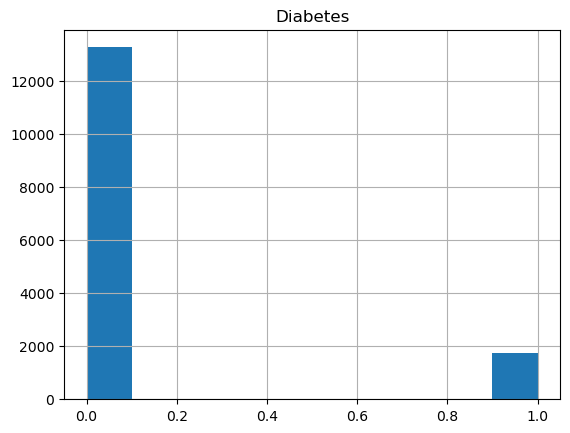

In [4]:
# Load Diabetes data from the .xpt file and setting 'SEQN' as the index for easier referencing
# Selecting only relevant columns and setting 'SEQN' as the index for easier referencing and renaming for better interpretability
diabetes = pd.read_sas('P_DIQ.xpt')[['SEQN','DIQ010']].set_index('SEQN').rename(columns={'DIQ010': 'Diabetes'})

# Codes
# 1	Yes		
# 2	No	
# 3	Borderline
# 7	Refused	
# 9	Don't know

diabetes.Diabetes = diabetes.Diabetes.replace({2: 0, 3: 1, 7: 0, 9: 0})

diabetes.hist()

In [5]:
diabetes.shape


(14986, 1)

In [6]:
# Choose columns to select from datasets
cols = ['SEQN', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ650', 'PAQ665', 'PAD680']

# Adults (older than 18)
# SEQN - Respondent sequence number         
# PAQ605 - Vigorous work activity            Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
# PAQ620 - Moderate work activity            Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
# PAQ635 - Walk or bicycle                   Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
# PAQ650 - Vigorous recreational activities  Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
# PAQ665 - Moderate recreational activities  Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
# PAD680 - Minutes sedentary activity        Codes: 0 to 1320: Range of Values, 7777: Refused, 9999: Don't know ; 5.39760535e-79

# Load Physical activity data
# Selecting only relevant columns and setting 'SEQN' as the index for easier referencing
physical_activity = pd.read_sas('P_PAQ.xpt')[cols].set_index('SEQN')

# Choose columns with discrete values
binary_cols = ['PAQ605', 'PAQ620', 'PAQ635', 'PAQ650', 'PAQ665']
new_names = ['Vigorous_work', 'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreational']

# Replace coded values in these columns: 2-> 0, 7 -> np.nan, 9 -> np.nan
# Replace missing values with mode
for col in binary_cols:
    physical_activity[col] = physical_activity[col].replace({2: 0, 7: np.nan, 9: np.nan})
    mode_value = physical_activity[col].mode()[0]
    physical_activity[col] = physical_activity[col].fillna(mode_value)

# Rename these columns for better interpretability of the data
for old, new in zip(binary_cols, new_names):
    physical_activity.rename(columns={old: new}, inplace=True)

# Rename PAD680 column
physical_activity.rename(columns={'PAD680': 'Sedentary_mins'}, inplace=True)

# Replace very small value (5.39760535e-79) in sedentary activity column with np.nan, since 0 is not realistic
physical_activity.Sedentary_mins = physical_activity.Sedentary_mins.apply(
    lambda x: np.nan if isinstance(x, float) and abs(x - 5.39760535e-79) < 1e-80 else x)

# Winsorize the invalid entries for Sedentary minutes (should be less than 1440 (24 hours))
physical_activity.Sedentary_mins = np.clip(physical_activity.Sedentary_mins, 1, 1440)

# Replace missing values in sedentary activity column with mode
physical_activity.Sedentary_mins = physical_activity.Sedentary_mins.fillna(physical_activity.Sedentary_mins.mode()[0])


# Create composite activity score
physical_activity['Activity_score'] = (physical_activity.Vigorous_work * 3 +
                                       physical_activity.Moderate_work * 2 +
                                       physical_activity.Walk_or_bicycle * 1 +
                                       physical_activity.Vigorous_recreational * 3 +
                                       physical_activity.Moderate_recreational * 2)

# Create column to categorize activity level
physical_activity['Activity_category'] = pd.cut(physical_activity.Activity_score,
                                                bins=[-1, 4, 8, 12],
                                                labels=['Low', 'Moderate', 'High'])

# Convert sedentary minutes to hours
physical_activity['Sedentary_hrs'] = physical_activity.Sedentary_mins / 60

# Create column to categorize sedentary behavior
physical_activity['Sedentary_category'] = pd.cut(physical_activity.Sedentary_hrs,
                                                 bins=[-1, 4, 8, 12, np.inf],
                                                 labels=['Low', 'Moderate', 'High', 'Very High'])

# Create inverse sedentary score
physical_activity['Inverse_sedentary_score'] = 4 - physical_activity.Sedentary_category.cat.codes

# Combine activity and sedentary score
physical_activity['Lifestyle_score'] = physical_activity.Activity_score + physical_activity.Inverse_sedentary_score

# Create column to categorize lifestyle
physical_activity['Lifestyle_category'] = pd.cut(physical_activity.Lifestyle_score,
                                                 bins=[-1, 4, 8, 12, np.inf],
                                                 labels=['Sedentary', 'Low Active', 'Moderate Active', 'Highly Active'])


In [7]:
physical_activity.shape

(9693, 13)

In [8]:
# Load smoke data
# Selecting only relevant column and setting 'SEQN' as the index for easier referencing
# SEQN - Respondent sequence number
# SMQ020 - Smoked at least 100 cigarettes in life
# Codes: Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
smoke = pd.read_sas('P_SMQ.xpt')[['SEQN', 'SMQ020']].set_index('SEQN')

# Rename SMQ020 column for better understanding of data
smoke.rename(columns={'SMQ020': 'Smoked'}, inplace=True)

# Encode negative answer as 0, refused and don't know as nan
smoke.Smoked = smoke.Smoked.replace({2: 0, 7: np.nan, 9: np.nan})

# Replace missing values with mode (after merging with sleep and lifestyle datasets only 5 missing entries will be there)
smoke.Smoked = smoke.Smoked.fillna(smoke.Smoked.mode()[0])


In [9]:
smoke.shape

(11137, 1)

In [10]:
# Load medical conditions data (family history of diabetes)
# Selecting only relevant column and setting 'SEQN' as the index for easier referencing
# SEQN - Respondent sequence number
# MCQ300C - Close relative had diabetes?
# MCQ220 - Ever told you had cancer or malignancy?
# Codes: Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
diabetes_hist = pd.read_sas('P_MCQ.xpt')[['SEQN', 'MCQ300C', 'MCQ220']].set_index('SEQN')

# Rename the column for better interpretability and understanding of data
diabetes_hist.rename(columns={'MCQ300C': 'Diabetes_family_history_coded'}, inplace=True)
diabetes_hist.rename(columns={'MCQ220': 'Cancer_coded'}, inplace=True)

# Replace 2 (No) with 0
diabetes_hist['Diabetes_family_history_coded'] = diabetes_hist.Diabetes_family_history_coded.replace({2: 0})
diabetes_hist['Cancer_coded'] = diabetes_hist.Cancer_coded.replace({2: 0})

# Replace 'Refused' (7), 'Don't know' (9), and missing values with 2 (Unknown)
diabetes_hist['Diabetes_family_history_coded'] = diabetes_hist.Diabetes_family_history_coded.replace({7: 2, 9: 2}).fillna(2)
diabetes_hist['Cancer_coded'] = diabetes_hist.Cancer_coded.replace({7: 2, 9: 2}).fillna(2)

# Map the values to meaningful labels for clarity
diabetes_hist['Diabetes_family_history'] = diabetes_hist['Diabetes_family_history_coded'].map({
    0: 'No',
    1: 'Yes',
    2: 'Unknown'
})
diabetes_hist['Cancer'] = diabetes_hist['Cancer_coded'].map({
    0: 'No',
    1: 'Yes',
    2: 'Unknown'
})


In [11]:
diabetes_hist.shape

(14986, 4)

**Merge sleep dataset with physical activity, smoked status and diabetes family history data**

In [12]:
# Merge sleep with physical activity data
sleep_lifestyle_diabetes = sleep.merge(physical_activity, left_index=True, right_index=True)

# Merge with smoke dataset
sleep_lifestyle_diabetes = sleep_lifestyle_diabetes.merge(smoke, left_index=True, right_index=True)

# Merge with diabetes dataset
sleep_lifestyle_diabetes = sleep_lifestyle_diabetes.merge(diabetes, left_index=True, right_index=True)

# Merge with diabetes family history dataset
sleep_lifestyle_diabetes = sleep_lifestyle_diabetes.merge(diabetes_hist, left_index=True, right_index=True)

print('Shape of merged dataset:', sleep_lifestyle_diabetes.shape)
print('Missing values of merged dataset: ',sleep_lifestyle_diabetes.isnull().sum().sum())
print('Columns after merging:', sleep_lifestyle_diabetes.columns.tolist())

Shape of merged dataset: (9480, 54)
Missing values of merged dataset:  0
Columns after merging: ['Bedtime_weekdays', 'Wake_time_weekdays', 'Sleep_hrs_weekdays', 'Bedtime_weekends', 'Wake_time_weekends', 'Sleep_hrs_weekends', 'Snore', 'Stop_breathing', 'Sleeping_problems', 'Sleepy_during_day', 'Bedtime_weekdays_hrs', 'Wake_time_weekdays_hrs', 'Bedtime_weekends_hrs', 'Wake_time_weekends_hrs', 'Bedtime_weekdays_hrs_sin', 'Bedtime_weekdays_hrs_cos', 'Wake_time_weekdays_hrs_sin', 'Wake_time_weekdays_hrs_cos', 'Bedtime_weekends_hrs_sin', 'Bedtime_weekends_hrs_cos', 'Wake_time_weekends_hrs_sin', 'Wake_time_weekends_hrs_cos', 'Social_Jetlag', 'Jetlag_hrs', 'Stop_breathing_missing', 'Snore_missing', 'Sleeping_problems_missing', 'Sleepy_during_day_missing', 'Sleep_Apnea_risk', 'Sleep_health', 'Sleep_midpoint_weekdays', 'Sleep_midpoint_weekends', 'Bedtime_SD', 'Sleep_Duration_SD', 'Sleep_schedule', 'Vigorous_work', 'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreationa

In [13]:
# Load Demographic data from the .xpt file
# Selecting only relevant columns and setting 'SEQN' as the index for easier referencing
demographic = pd.read_sas('P_DEMO.xpt')[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'INDFMPIR']].set_index('SEQN')

# Rename columns for better readability and understanding of the data
demographic.rename(columns={'RIAGENDR': 'Gender',                # Gender
                            'RIDAGEYR': 'Age',                   # Age in years at screening
                            'INDFMPIR': 'Poverty_index',         # Ratio of family income to poverty
                            'RIDRETH3': 'Race'}, inplace=True)   # Race/Hispanic origin w/ NH Asian

# Coded values
# 'Gender': 1 - Male, 2 - Female
# 'Race': 1	- Mexican American,	2 -	Other Hispanic,	3 -	Non-Hispanic White,	4 -	Non-Hispanic Black,	
#         6 - Non-Hispanic Asian, 7 - Other Race (Including Multi-Racial)
# 'Poverty_index: 0 to 4.98	Range of Values	
#                 5	Value greater than or equal to 5.00	

# Replace coded values in Gender column for beter understanding data
demographic.Gender = demographic.Gender.replace({2: 0})

print('Shape of demographic dataset:', demographic.shape)
print('Missing values of demographic dataset: ',demographic.isnull().sum().sum())

Shape of demographic dataset: (15560, 4)
Missing values of demographic dataset:  2201


In [14]:
# Load BMI data from the .xpt file
# Selecting only relevant columns and setting 'SEQN' as the index for easier referencing
# BMXWAIST - Waist Circumference (cm)
bmi = pd.read_sas('P_BMX.xpt')[['SEQN', 'BMXBMI', 'BMXWAIST']].set_index('SEQN') 

# Rename columns for better readability and understanding of the data
bmi.rename(columns={'BMXBMI': 'BMI', 'BMXWAIST': 'Waist_cm'}, inplace=True)                    # Body Mass Index (kg/m**2)

print('Shape of bmi dataset:', bmi.shape)
print('Missing values of bmi dataset: \n',bmi.isnull().sum())

Shape of bmi dataset: (14300, 2)
Missing values of bmi dataset: 
 BMI         1163
Waist_cm    1726
dtype: int64


Number of entries out of the biologically plausible range ( BMI < 15 and BMI > 50):  175


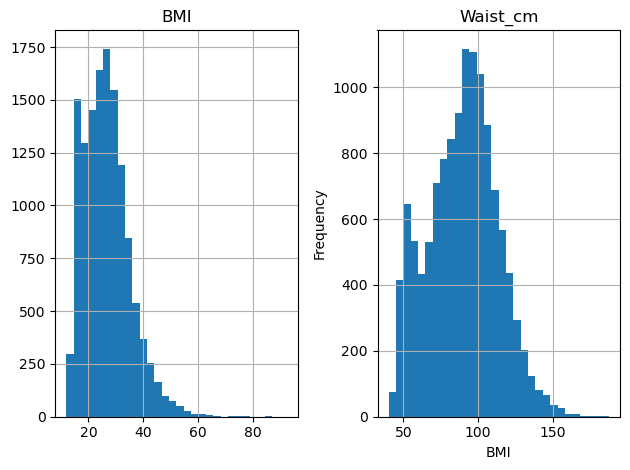

In [15]:
print('Number of entries out of the biologically plausible range ( BMI < 15 and BMI > 50): ', ((bmi.BMI < 12) | (bmi.BMI > 50)).sum())

# Plot distribution before Winsorization
bmi.hist(bins=30)
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.tight_layout()

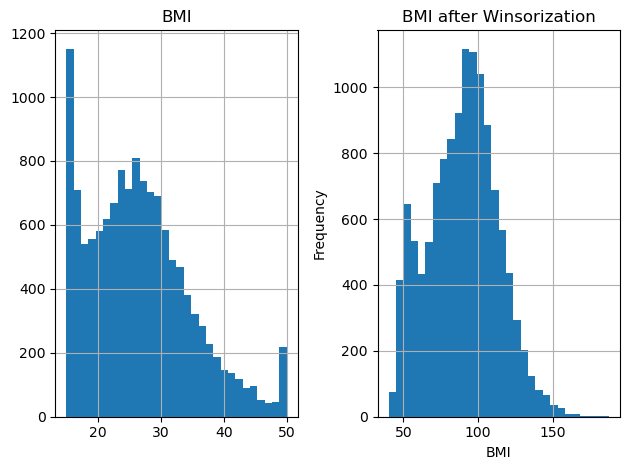

In [16]:
# Winsorize BMI within biologically plausible range ( BMI > 15 and BMI < 50)
bmi.BMI = np.clip(bmi.BMI, 15, 50)

# Plot distribution after Winsorization
bmi.hist(bins=30)
plt.title('BMI after Winsorization')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.tight_layout()

In [17]:
# Load Blood Pressure data from the .xpt file and setting 'SEQN' as the index for easier referencing
b_p = pd.read_sas('P_BPXO.xpt').set_index('SEQN')

# Choose columns with Systolic Blood Pressure measurements (mm Hg)
# 'BPXOSY1', 'BPXOSY2', 'BPXOSY3' - columns with Systolic Blood Pressure measurements (1st, 2nd and 3rd readings respectively)
bp_cols_sys = ['BPXOSY1', 'BPXOSY2', 'BPXOSY3'] 

# Choose columns with Diastolic Blood Pressure measurements (mm Hg)
# 'BPXODI1', 'BPXODI2', 'BPXODI3' - columns with Diastolic Blood Pressure measurements (1st, 2nd and 3rd readings respectively)
bp_cols_dia = ['BPXODI1', 'BPXODI2', 'BPXODI3']

# Create a column with the average Systolic Blood Pressure
b_p['BP_Systolic'] = b_p[bp_cols_sys].mean(axis=1, skipna=True)

# Create a column with the average Diastolic Blood Pressure
b_p['BP_Diastolic'] = b_p[bp_cols_dia].mean(axis=1, skipna=True)

# Choose the columns with the average Blood Pressure measurements for further analysis
blood_pressure = b_p[['BP_Systolic', 'BP_Diastolic']]

print('Shape of blood pressure dataset:', blood_pressure.shape)
print('Missing values of blood pressure dataset: \n',blood_pressure.isnull().sum())

Shape of blood pressure dataset: (11656, 2)
Missing values of blood pressure dataset: 
 BP_Systolic     1303
BP_Diastolic    1303
dtype: int64


In [18]:
# Lipoprotein

# Load High-Density Lipoprotein data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
HDL = pd.read_sas('P_HDL.xpt').set_index('SEQN')

# Choose the column 'LBDHDD': Direct HDL-Cholesterol (mg/dL)                                          missing values: 1370
# Rename 'LBDHDD' column for better readability and understanding of the data                         shape: (12198, 1)
HDL = HDL[['LBDHDD']].rename(columns={'LBDHDD': 'HDL'})

# Load Low-Density Lipoprotein data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
LDL = pd.read_sas('P_TRIGLY.xpt').set_index('SEQN')

# Choose the necessary coumns:                                                                         missing values:
# 'LBXTR' - Triglycerides (mg/dL) and 'LBDLDL' - LDL-Cholesterol, Friedewald (mg/dL)                   LDL             473        
# and rename them for better readability and understanding of the data                                 Triglycerides    440
LDL = LDL[['LBXTR', 'LBDLDL']].rename(columns={'LBXTR': 'Triglycerides', 'LBDLDL': 'LDL'})            # shape: (5090, 2)


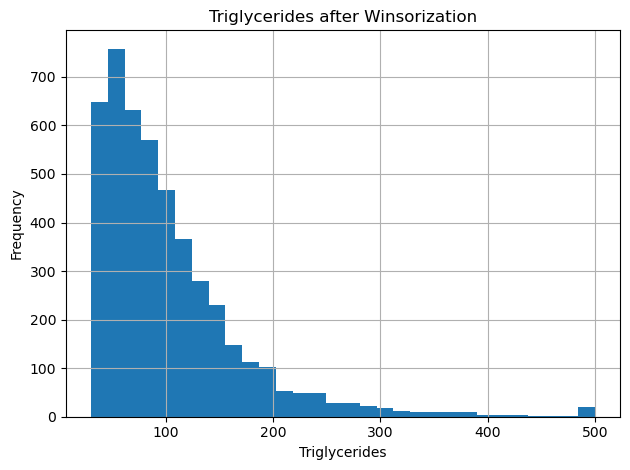

In [19]:
# Winsorize Triglycerides within biologically plausible range (between 30 and 500)
LDL.Triglycerides = np.clip(LDL.Triglycerides, 30, 500)

# Plot distribution after Winsorization
LDL.Triglycerides.hist(bins=30)
plt.title('Triglycerides after Winsorization')
plt.xlabel('Triglycerides')
plt.ylabel('Frequency')
plt.tight_layout()

Statistics:

       Fasting_glucose      Insulin
count      4744.000000  4625.000000
mean        111.182125    14.975684
std          36.314648    22.845041
min          47.000000     0.710000
25%          95.000000     6.310000
50%         102.000000    10.180000
75%         112.000000    16.610000
max         524.000000   512.500000
               GHB
count  9737.000000
mean      5.765575
std       1.066217
min       2.800000
25%       5.200000
50%       5.500000
75%       5.900000
max      16.200000


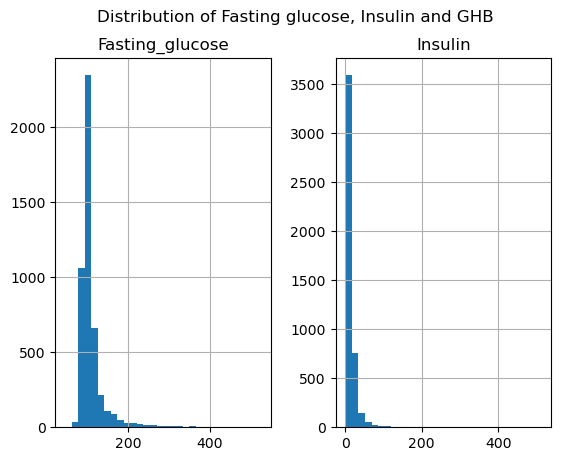

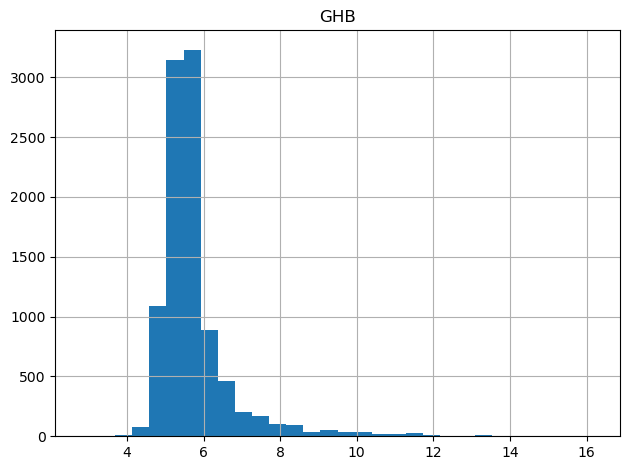

In [20]:
# GLUCOSE METABOLISM AND DIABETES RISK

# Load Glycohemoglobin data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
GHB = pd.read_sas('P_GHB.xpt').set_index('SEQN')

# Rename 'LBXGH' column (Glycohemoglobin (%)) for better readability and understanding of the dataLBXGH 
GHB.rename(columns={'LBXGH': 'GHB'}, inplace=True)


# Load Fasting Glucose data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
fasting_glucose = pd.read_sas('P_GLU.xpt').set_index('SEQN')

# Choose the column 'LBXGLU' - Fasting Glucose (mg/dL)
# Rename 'LBXTC' column for better readability and understanding of the data
fasting_glucose = fasting_glucose[['LBXGLU']].rename(columns={'LBXGLU':'Fasting_glucose'})    #(5090, 1)


# Load Insulin data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
insulin = pd.read_sas('P_INS.xpt').set_index('SEQN')

# Choose the column 'LBXIN' - Insulin (μU/mL)
# Rename 'LBXIN' column for better readability and understanding of the data
insulin = insulin[['LBXIN']].rename(columns={'LBXIN': 'Insulin'})                               #(5090, 1)

# Create separate DataFrame for analyzing metabolism and diabetes risk 
sugar = fasting_glucose.merge(insulin, left_index=True, right_index=True)

# Statistics for Fasting glucose , Insulin and GHB
print('Statistics:\n')
print(sugar.describe())
print(GHB.describe())

# Plot histogram of Fasting glucose and Insulin
sugar.hist(bins=30)
plt.suptitle('Distribution of Fasting glucose, Insulin and GHB')

# Plot histogram of GHB
GHB.hist(bins=30)

plt.tight_layout()

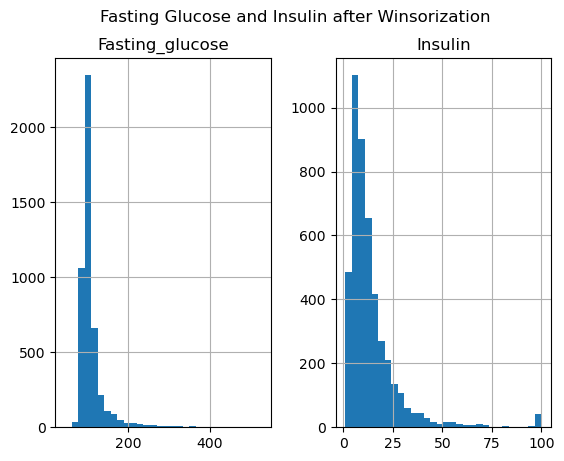

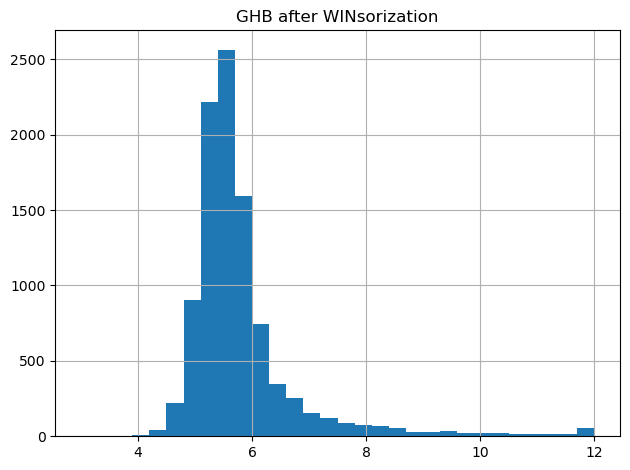

In [21]:
# Winsorize Insulin and GHB
#sugar.Fasting_glucose = np.clip(sugar.Fasting_glucose, 50, 300)
sugar.Insulin = np.clip(sugar.Insulin, 1, 100)
GHB.GHB = np.clip(GHB.GHB, 3, 12)

# Plot distribution after Winsorization
sugar.hist(bins=30)
plt.suptitle('Fasting Glucose and Insulin after Winsorization')


GHB.hist(bins=30)
plt.title('GHB after WINsorization')

plt.tight_layout()

In [22]:
# INFLAMMATION 

# Load High-Sensitivity C-Reactive Protein data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
CRP = pd.read_sas('P_HSCRP.xpt').set_index('SEQN')

# Choose the column 'LBXHSCRP' - HS C-Reactive Protein (mg/L)
# Rename 'LBXHSCRP' column for better readability and understanding of the data
CRP = CRP[['LBXHSCRP']].rename(columns={'LBXHSCRP': 'CRP'})


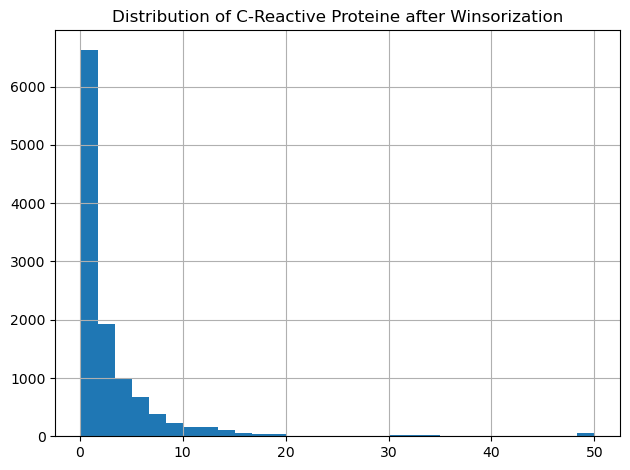

In [23]:
# Replace values below 0.1 with 0.1 and values above 50 with 50
CRP.CRP = np.clip(CRP.CRP, 0.1, 50)

# Check the distribution after winsorization
CRP.hist(bins=30)
plt.title('Distribution of C-Reactive Proteine after Winsorization')

plt.tight_layout()

In [24]:
# STANDARD BIOCHEMISTRY PROFILE

# Load Standard Biochemistry Profile data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
bio_pro = pd.read_sas('P_BIOPRO.xpt').set_index('SEQN')

# Choose columns that can be useful in analyzing circadian rhythms and metabolism
# Liver enzymes: 'LBXSATSI' - Alanine Aminotransferase (ALT) (U/L),
#                'LBXSASSI' - Aspartate Aminotransferase (AST) (U/L),
#                'LBXSGTSI' - Gamma Glutamyl Transferase (GGT) (IU/L),
# 'LBXSUA' - Uric acid (mg/dL),
# 'LBXSCR' - Creatinine, refrigerated serum (mg/dL)
# 'LBXSAL' - Albumin, refrigerated serum (g/dL)
# 'LBXSBU' - Blood Urea Nitrogen (mg/dL)
# 'LBXSLDSI' - Lactate Dehydrogenase (LDH) (IU/L)
# 'LBXSGB' - Globulin (g/dL)
# 'LBXSTP' - Total Protein (g/dL)
# 'LBXSCH' - Cholesterol, refrigerated serum (mg/dL)

# renaming them for better readability and understanding of the data
cols = ['LBXSATSI', 'LBXSASSI', 'LBXSGTSI', 'LBXSUA', 'LBXSCR', 'LBXSAL', 'LBXSBU', 'LBXSLDSI', 'LBXSGB', 'LBXSTP', 'LBXSCH']
bio_pro = bio_pro[cols].rename(columns={
    'LBXSATSI': 'ALT',
    'LBXSASSI': 'AST',
    'LBXSGTSI': 'GGT',
    'LBXSUA': 'Uric_acid',
    'LBXSCR': 'Creatinine',
    'LBXSAL': 'Albumin',
    'LBXSBU': 'BUN',
    'LBXSLDSI': 'LDH',
    'LBXSGB': 'Globulin',
    'LBXSTP': 'Total_protein',
    'LBXSCH': 'Cholesterol'
    })
bio_pro.columns

Index(['ALT', 'AST', 'GGT', 'Uric_acid', 'Creatinine', 'Albumin', 'BUN', 'LDH',
       'Globulin', 'Total_protein', 'Cholesterol'],
      dtype='object')

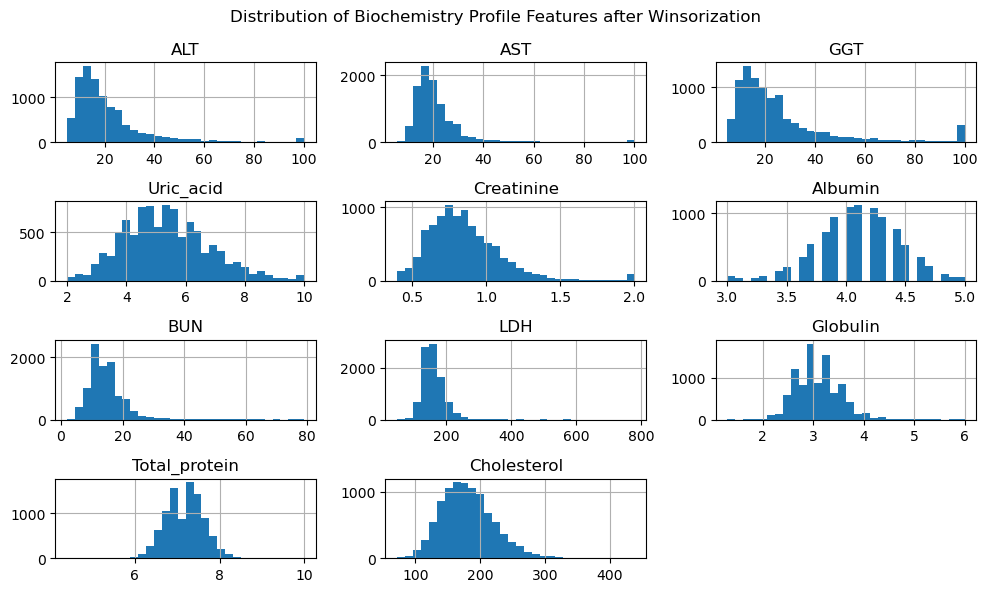

In [25]:
# Winsorize standard biochemistry profile features to reduce outliers and stabilize model,
# staying within the range of biological plausibility and without distorting data
bio_pro.ALT = np.clip(bio_pro.ALT, 5, 100)
bio_pro.AST = np.clip(bio_pro.AST, 5, 100)
bio_pro.GGT = np.clip(bio_pro.GGT, 5, 100)
bio_pro.Uric_acid = np.clip(bio_pro.Uric_acid, 2, 10)
bio_pro.Creatinine = np.clip(bio_pro.Creatinine, 0.4, 2)
bio_pro.Albumin = np.clip(bio_pro.Albumin, 3, 5)

# Check the distribution after winsorization
bio_pro.hist(bins=30, figsize=(10,6))

plt.suptitle('Distribution of Biochemistry Profile Features after Winsorization')
plt.tight_layout()

In [26]:
# Load ACR data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
ACR = pd.read_sas('P_ALB_CR.xpt').set_index('SEQN')[['URDACT']]
# URDACT - Albumin creatinine ratio (mg/g)
# Rename the column for better interpretability
ACR.rename(columns={'URDACT': 'ACR'}, inplace=True)
ACR.describe()

ACR
count  12509.000000
mean      44.060051
std      302.925541
min        0.270000
25%        5.200000
50%        8.210000
75%       15.830000
max    11676.920000

array([[<Axes: title={'center': 'ACR'}>]], dtype=object)

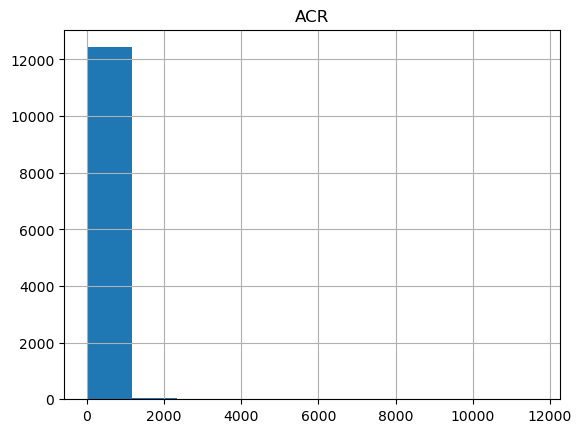

In [27]:
ACR.hist()

In [28]:
# HORMONES

# Load Hormones profile from .xpt file
# Setting 'SEQN' as the index for easier referencing
hormones = pd.read_sas('P_TST.xpt').set_index('SEQN')

# Hormones like SHBG and estradiol directly modulate insulin sensitivity and fat storage
# 'LBXSHBG' - SHBG (nmol/L) : Binds sex hormones (testosterone/estrogen); low SHBG -> insulin resistance, obesity
# 'LBXEST' - Estradiol (pg/mL) : Estrogen regulates fat distribution, glucose metabolism, and inflammation
# 'LBXAND' - Androstenedione (ng/dL) : Precursor to testosterone; elevated levels -> visceral fat, metabolic syndrome
# 'LBX17H' - 17α-hydroxyprogesterone (ng/dL) : Linked to adrenal function; dysregulation -> cortisol/metabolic disturbances
# 'LBXLUH' - Luteinizing Hormone (mIU/mL) : Regulate sex hormones; imbalances -> PCOS (strongly tied to insulin resistance)
# 'LBXFSH' - Follicle Stimulating Hormone (mIU/mL)


# Choose columns that can be useful in analyzing circadian rhythms and metabolism
cols = ['LBXSHBG', 'LBXEST', 'LBXAND', 'LBXLUH', 'LBXFSH']
hormones = hormones[cols]

# Rename them for better readability and understanding of the data
cols_new = ['SHBG', 'Estradiol', 'Androstenedione', 'Luteinizing_hormone', 'Follicle_stimulating_hormone']

for old, new in zip(cols, cols_new):
    hormones.rename(columns={old: new}, inplace=True)


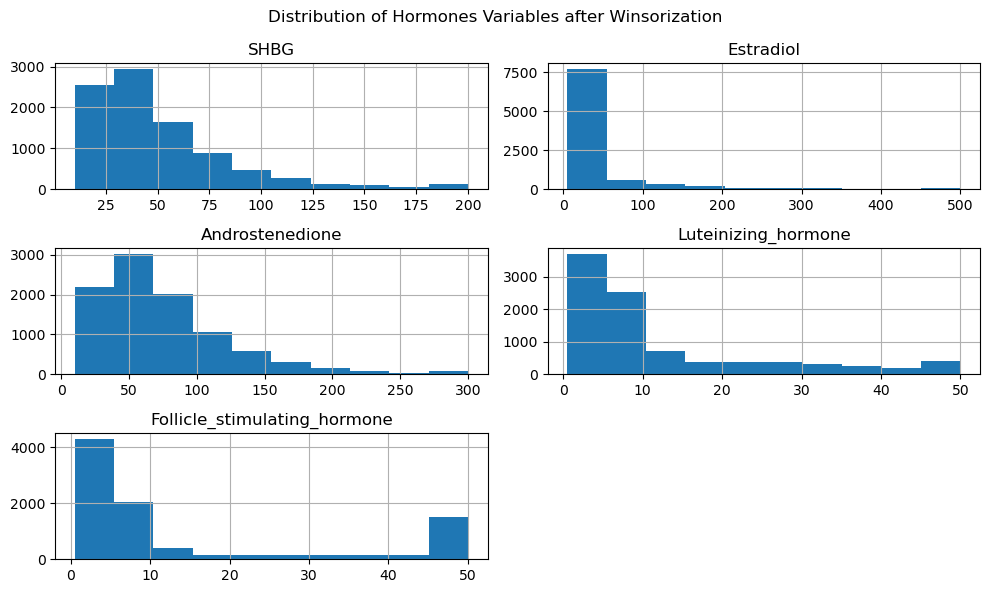

In [29]:
# Winsorize standard hormones profile features to reduce outliers and stabilize model,
# staying within the range of biological plausibility and without distorting data
hormones.SHBG = np.clip(hormones.SHBG, 10, 200)
hormones.Estradiol = np.clip(hormones.Estradiol, 5, 500)
hormones.Androstenedione = np.clip(hormones.Androstenedione, 10, 300)
hormones.Luteinizing_hormone = np.clip(hormones.Luteinizing_hormone, 0.5, 50)
hormones.Follicle_stimulating_hormone = np.clip(hormones.Follicle_stimulating_hormone, 0.5, 50)

# Check the distribution after winsorization
hormones.hist(figsize=(10,6))
plt.suptitle('Distribution of Hormones Variables after Winsorization')

plt.tight_layout()

In [30]:
# Dietary Factors

# Choose nesessary features
# DR1TKCAL - Energy (kcal)
# DR1TPROT - Protein (gm)
# DR1TCARB - Carbohydrate (gm)
# DR1TSUGR - Total sugars (gm)
# DR1TFIBE - Dietary fiber (gm)
# DR1TTFAT - Total fat (gm)
# DR1TSFAT - Total saturated fatty acids (gm)
# DR1TSODI - Sodium (mg)
# DR1TPOTA - Potassium (mg)
# DR1TCAFF - Caffeine (mg)
# DR1TALCO - Alcohol (gm)
# DR1DAY - Intake day of the week (could be relevant for circadian rhythm analysis)
# DRQSDIET - On special diet?
# DRQSDT1 to DRQSDT12 - Various types of diets (especially DRQSDT7 - Diabetic diet)

# DR1TMFAT - Total monounsaturated fatty acids (gm)
# DR1TPFAT - Total polyunsaturated fatty acids (gm)

'''
DRQSDIET - On special diet?
DRQSDT1 - Weight loss/Low calorie diet
DRQSDT2 - Low fat/Low cholesterol diet
DRQSDT3 - Low salt/Low sodium diet
DRQSDT4 - Sugar free/Low sugar diet
DRQSDT7 - Diabetic diet
DRQSDT9 - Low carbohydrate diet
DRQSDT10 - High protein diet

DR1TATOC - Vitamin E as alpha-tocopherol (mg)
DR1TVARA - Vitamin A, RAE (mcg)
DR1TVC - Vitamin C (mg)
DR1TVD - Vitamin D (D2 + D3) (mcg)
DR1TCALC - Calcium (mg)
DR1TIRON - Iron (mg)
DR1TZINC - Zinc (mg)
DR1TSELE - Selenium (mcg)

DR1TVB1 - Thiamin (Vitamin B1) (mg)
DR1TVB2 - Riboflavin (Vitamin B2) (mg)
DR1TNIAC - Niacin (mg)
DR1TVB6 - Vitamin B6 (mg)
DR1TFOLA - Total folate (mcg)
DR1TVB12 - Vitamin B12 (mcg)

DR1TACAR - Alpha-carotene (mcg)
DR1TBCAR - Beta-carotene (mcg)
DR1TLYCO - Lycopene (mcg)
DR1TLZ - Lutein + zeaxanthin (mcg)
'''

# Load Total Nutrient Intake (Day 1) from .xpt file
# Setting 'SEQN' as the index for easier referencing
nutrients_1 = pd.read_sas('P_DR1TOT.xpt').set_index('SEQN')

# Choose columns that can be useful in analyzing circadian rhythms and metabolism
# renaming them for better readability and understanding of the data
cols_1 = [
    'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT',
    'DR1TSFAT', 'DR1TSODI', 'DR1TPOTA', 'DR1TCAFF', 'DR1TALCO',
    'DR1TMFAT', 'DR1TPFAT',
    'DR1TATOC', 'DR1TVARA', 'DR1TVC', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TZINC', 'DR1TSELE',
    'DR1TVB1', 'DR1TVB2', 'DR1TNIAC', 'DR1TVB6', 'DR1TFOLA', 'DR1TVB12',
    'DR1TACAR', 'DR1TBCAR', 'DR1TLYCO', 'DR1TLZ',
    'DRQSDIET', 'DRQSDT1', 'DRQSDT2', 'DRQSDT3', 'DRQSDT4', 'DRQSDT7', 'DRQSDT9', 'DRQSDT10']

# New names for the columns
cols_1_new = [
    'Energy_1', 'Protein_1', 'Carbohydrate_1', 'Total_sugars_1', 'Dietary_fiber_1', 'Total_fat_1',
    'Total_saturated_fatty_acids_1', 'Sodium_1', 'Potassium_1', 'Caffeine_1', 'Alcohol_1',
    'Total_monounsaturated_fatty_acids_1', 'Total_polyunsaturated_fatty_acids_1',
    'Vitamin_E_1', 'Vitamin_A_1', 'Vitamin_C_1', 'Vitamin_D_1', 'Calcium_1', 'Iron_1', 'Zinc_1', 'Selenium_1',
    'B1_1', 'B2_1', 'Niacin_1', 'B6_1', 'Total_folate_1', 'B12_1',
    'Alpha_carotene_1', 'Beta_carotene_1', 'Lycopene_1', 'Lutein_zeaxanthin_1',
    'Diet', 'Weight_loss_diet', 'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Diabetic_diet', 'Low_carbohydrate_diet', 'High_protein_diet',
    
]

nutrients_1 = nutrients_1[cols_1].rename(columns=dict(zip(cols_1, cols_1_new)))

# Load Total Nutrient Intake (Day 2) from .xpt file
# Setting 'SEQN' as the index for easier referencing
nutrients_2 = pd.read_sas('P_DR2TOT.xpt').set_index('SEQN')

# Choose columns that can be useful in analyzing circadian rhythms and metabolism
# renaming them for better readability and understanding of the data
cols_2 = [
    'DR2TKCAL', 'DR2TPROT', 'DR2TCARB', 'DR2TSUGR', 'DR2TFIBE', 'DR2TTFAT',
    'DR2TSFAT', 'DR2TSODI', 'DR2TPOTA', 'DR2TCAFF', 'DR2TALCO', 'DR2TMFAT', 'DR2TPFAT',
    'DR2TATOC', 'DR2TVARA', 'DR2TVC', 'DR2TVD', 'DR2TCALC', 'DR2TIRON', 'DR2TZINC', 'DR2TSELE',
    'DR2TVB1', 'DR2TVB2', 'DR2TNIAC', 'DR2TVB6', 'DR2TFOLA', 'DR2TVB12',
    'DR2TACAR', 'DR2TBCAR', 'DR2TLYCO', 'DR2TLZ',
]

# New names for the columns
cols_2_new = [
    'Energy_2', 'Protein_2', 'Carbohydrate_2', 'Total_sugars_2', 'Dietary_fiber_2', 'Total_fat_2',
    'Total_saturated_fatty_acids_2', 'Sodium_2', 'Potassium_2', 'Caffeine_2', 'Alcohol_2',
    'Total_monounsaturated_fatty_acids_2', 'Total_polyunsaturated_fatty_acids_2',
    'Vitamin_E_2', 'Vitamin_A_2', 'Vitamin_C_2', 'Vitamin_D_2', 'Calcium_2', 'Iron_2', 'Zinc_2', 'Selenium_2',
    'B1_2', 'B2_2', 'Niacin_2', 'B6_2', 'Total_folate_2', 'B12_2',
    'Alpha_carotene_2', 'Beta_carotene_2', 'Lycopene_2', 'Lutein_zeaxanthin_2',
]

nutrients_2 = nutrients_2[cols_2].rename(columns=dict(zip(cols_2, cols_2_new)))

# Merge both Day 1 and Day 2 datasets
nutrients = nutrients_1.merge(nutrients_2, left_index=True, right_index=True)
nutrients.columns

# Replace very small nuber (5.39760535e-79) with 0 
cols_replace = ['Caffeine_1', 'Caffeine_2', 'Alcohol_1','Alcohol_2']
for col in cols_replace:
    nutrients[col] = nutrients[col].apply(lambda x: 0 if isinstance(x, float) and abs(x - 5.39760535e-79) < 1e-80 else x)

# Create columns average of Day 1 and Day 2
cols_avg = [
    'Energy', 'Protein', 'Carbohydrate', 'Total_sugars', 'Dietary_fiber', 'Total_fat',
    'Total_saturated_fatty_acids', 'Sodium', 'Potassium', 'Caffeine', 'Alcohol',
    'Total_monounsaturated_fatty_acids', 'Total_polyunsaturated_fatty_acids',
    'Vitamin_E', 'Vitamin_A', 'Vitamin_C', 'Vitamin_D', 'Calcium', 'Iron', 'Zinc', 'Selenium',
    'B1', 'B2', 'Niacin', 'B6', 'Total_folate', 'B12',
    'Alpha_carotene', 'Beta_carotene', 'Lycopene', 'Lutein_zeaxanthin',
]

# Calculate the average for each pair of variables from Day 1 and Day 2
# If one of the entries is nan, choose non-nan entry as average 
for col in cols_avg:
    nutrients[col] = nutrients[[f'{col}_1', f'{col}_2']].mean(skipna=True, axis=1)
    
    # Drop columns from Day 1 and Day 2 observations, leaving the average
    nutrients.drop([f'{col}_1', f'{col}_2'], axis=1, inplace=True)

# Fill missing values with 0 for diet columns
diets = ['Diet', 'Weight_loss_diet', 'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Diabetic_diet', 'Low_carbohydrate_diet', 'High_protein_diet']
nutrients[diets] = nutrients[diets].fillna(0)

# Replace encoded entries
nutrients.Diet = nutrients.Diet.replace({2: 0, 9: 0})
nutrients[diets] = nutrients[diets].replace({2: 1, 3: 1, 4: 1, 7: 1, 9: 1, 10: 1})


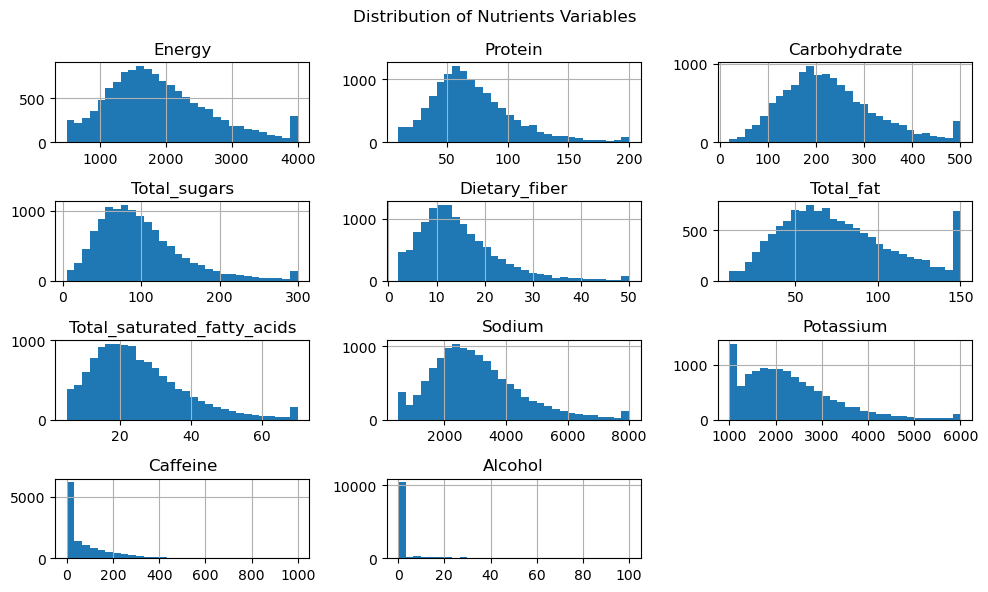

In [31]:
# Winsorize standard hormones profile features to reduce outliers and stabilize model,
# staying within the range of biological plausibility and without distorting data
plausible_ranges = {
    'Energy': [500, 4000],
    'Protein': [10, 200],
    'Carbohydrate': [20, 500],
    'Total_sugars': [5, 300],
    'Dietary_fiber': [2, 50],
    'Total_fat': [10, 150],
    'Total_saturated_fatty_acids': [5, 70],
    'Sodium': [500, 8000],
    'Potassium': [1000, 6000],
    'Caffeine': [0, 1000],
    'Alcohol': [0, 100]}

for var in plausible_ranges.keys():
    nutrients[var] = np.clip(nutrients[var], plausible_ranges[var][0], plausible_ranges[var][1])

winsorised = [var for var in plausible_ranges.keys()]

# Check the distribution after winsorization
nutrients[winsorised].hist(bins=30, figsize=(10,6))
plt.suptitle('Distribution of Nutrients Variables')

plt.tight_layout()

**Merge datasets**

In [32]:
# Merge demographic data with hormones dataset
merged_data = demographic.merge(hormones, left_index=True, right_index=True)

# Merge bmi dataset with merged dataset
merged_data = merged_data.merge(bmi, left_index=True, right_index=True)

# Merge blood pressure dataset with the merged data
merged_data = merged_data.merge(blood_pressure, left_index=True, right_index=True)

# Merge HDL dataset with the merged data
merged_data = merged_data.merge(HDL, left_index=True, right_index=True)

# Merge GHB dataset with the merged data
merged_data = merged_data.merge(GHB, left_index=True, right_index=True)

# Merge CRP dataset with the merged data
merged_data = merged_data.merge(CRP, left_index=True, right_index=True)

# Merge biochemistry profle dataset with the merged data
merged_data = merged_data.merge(bio_pro, left_index=True, right_index=True)

# Merge ACR dataset with the merged data
merged_data = merged_data.merge(ACR, left_index=True, right_index=True)

# Merge nutrients dataset with the merged data
merged_data = merged_data.merge(nutrients, left_index=True, right_index=True)

# Merge LDL data with the merged dataset
merged_data = merged_data.merge(LDL, left_index=True, right_index=True)

# Merge sugar dataset with the merged dataset
merged_data = merged_data.merge(sugar, left_index=True, right_index=True)

print('Merged dataset: ', merged_data.shape)
print('Columns (merged data):\n', merged_data.columns)

Merged dataset:  (5090, 71)
Columns (merged data):
 Index(['Gender', 'Age', 'Race', 'Poverty_index', 'SHBG', 'Estradiol',
       'Androstenedione', 'Luteinizing_hormone',
       'Follicle_stimulating_hormone', 'BMI', 'Waist_cm', 'BP_Systolic',
       'BP_Diastolic', 'HDL', 'GHB', 'CRP', 'ALT', 'AST', 'GGT', 'Uric_acid',
       'Creatinine', 'Albumin', 'BUN', 'LDH', 'Globulin', 'Total_protein',
       'Cholesterol', 'ACR', 'Diet', 'Weight_loss_diet', 'Low_fat_diet',
       'Low_salt_diet', 'Sugar_free_diet', 'Diabetic_diet',
       'Low_carbohydrate_diet', 'High_protein_diet', 'Energy', 'Protein',
       'Carbohydrate', 'Total_sugars', 'Dietary_fiber', 'Total_fat',
       'Total_saturated_fatty_acids', 'Sodium', 'Potassium', 'Caffeine',
       'Alcohol', 'Total_monounsaturated_fatty_acids',
       'Total_polyunsaturated_fatty_acids', 'Vitamin_E', 'Vitamin_A',
       'Vitamin_C', 'Vitamin_D', 'Calcium', 'Iron', 'Zinc', 'Selenium', 'B1',
       'B2', 'Niacin', 'B6', 'Total_folate', 'B12',

**Missing values of merged data**

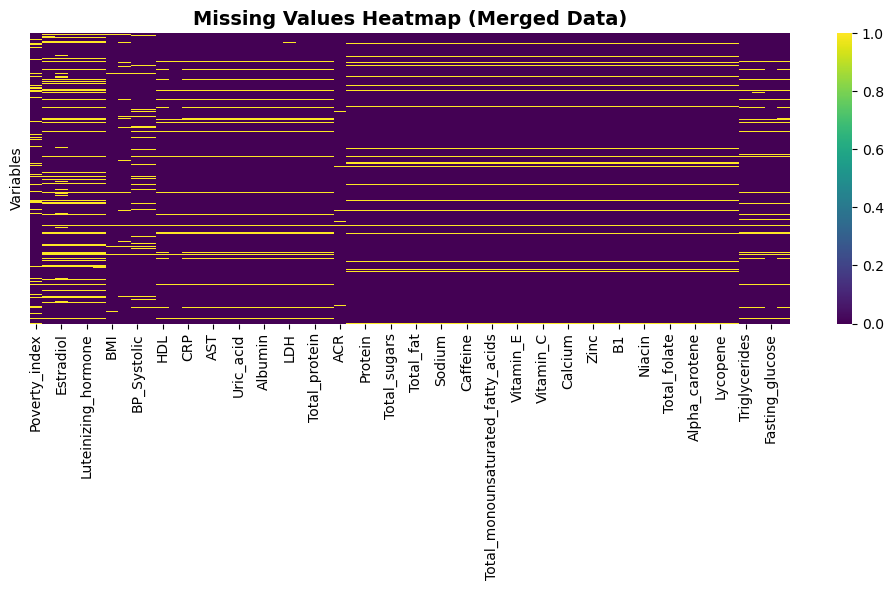

In [33]:
# Check the distribution and correlation of missing values
missing_cols = merged_data.columns[merged_data.isnull().any()].tolist()

fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(merged_data[missing_cols].isnull(), cmap='viridis', annot=False, yticklabels=False, ax=ax)
ax.set_title('Missing Values Heatmap (Merged Data)', fontsize=14, fontweight='semibold')
ax.set_ylabel('Variables')

plt.tight_layout()

In [34]:
# Find rows with more than 50% of missing values
missing_threshold = 0.5      
    
# Mask for rows to drop (have more missing values than threshold)
rows_to_drop = merged_data.isnull().mean(axis=1) > missing_threshold

print(f'Dropping {rows_to_drop.sum()} out of {merged_data.shape[0]} rows with >50% missing')

# Drop rows with missing values in Fasting_glucose column (since will be used as target in the analysis)
merged_data.dropna(subset=['Fasting_glucose'], axis=0, inplace=True)

# Drop rows with missing values more than threshold
merged_data_cleaned = merged_data.loc[~rows_to_drop].copy()

# Missingness perecntages after dropping
missing_perc_after = merged_data_cleaned[missing_cols].isnull().mean() * 100
print('Missing % after dropping:')
print(missing_perc_after.round(2))


Dropping 145 out of 5090 rows with >50% missing
Missing % after dropping:
Poverty_index                        12.86
SHBG                                 12.63
Estradiol                            15.35
Androstenedione                      12.37
Luteinizing_hormone                  12.54
Follicle_stimulating_hormone         12.86
BMI                                   1.46
Waist_cm                              3.82
BP_Systolic                           9.20
BP_Diastolic                          9.20
HDL                                   1.95
GHB                                   0.26
CRP                                   2.62
ALT                                   2.40
AST                                   2.72
GGT                                   2.40
Uric_acid                             2.40
Creatinine                            2.36
Albumin                               2.34
BUN                                   2.40
LDH                                   3.86
Globulin               

### Final merging, additional features, and log transformation

In [35]:
# Merge with merged sleep, physical activity and smoked status data
merged_data_cleaned = merged_data_cleaned.merge(sleep_lifestyle_diabetes, left_index=True, right_index=True)
print('Shape of dataset after final merging: ', merged_data_cleaned.shape)

# Calculate eGFR (estimated glomerular filtration rate) for kidney function
merged_data_cleaned['eGFR'] = 175 * (merged_data_cleaned.Creatinine ** (-1.154)) * (merged_data_cleaned.Age ** (-0.203))  
merged_data_cleaned.eGFR = merged_data_cleaned.apply(lambda row: row.eGFR * 0.742 if row.Gender == 0 else row.eGFR, axis=1)

# Log - transform skewed features
skewed_cols = ['CRP', 'ALT', 'AST', 'GGT', 'Estradiol', 'Luteinizing_hormone', 'Follicle_stimulating_hormone', 'SHBG',
               'Triglycerides', 'Insulin', 'Fasting_glucose', 'Total_saturated_fatty_acids', 'Cholesterol','Total_sugars',
               'Caffeine', 'Alcohol', 'Creatinine', 'ACR', 'Vitamin_A', 'Zinc', 'B12', 'Alpha_carotene', 'Beta_carotene', 'Lycopene']

for col in skewed_cols:
    merged_data_cleaned[f'{col}_log'] = np.log1p(merged_data_cleaned[col])

print('Shape of final dataset after log-transformation:', merged_data_cleaned.shape)
print('Missing values: ', merged_data_cleaned.isnull().sum())

# Save cleaned small dataset to csv file for further analysis
merged_data_cleaned.to_csv('circadian_metabolism_data.csv')

Shape of dataset after final merging:  (4016, 125)
Shape of final dataset after log-transformation: (4016, 150)
Missing values:  Gender                  0
Age                     0
Race                    0
Poverty_index         523
SHBG                  491
                     ... 
Zinc_log              270
B12_log               270
Alpha_carotene_log    270
Beta_carotene_log     270
Lycopene_log          270
Length: 150, dtype: int64


In [36]:
merged_data_cleaned.columns[:50]

Index(['Gender', 'Age', 'Race', 'Poverty_index', 'SHBG', 'Estradiol',
       'Androstenedione', 'Luteinizing_hormone',
       'Follicle_stimulating_hormone', 'BMI', 'Waist_cm', 'BP_Systolic',
       'BP_Diastolic', 'HDL', 'GHB', 'CRP', 'ALT', 'AST', 'GGT', 'Uric_acid',
       'Creatinine', 'Albumin', 'BUN', 'LDH', 'Globulin', 'Total_protein',
       'Cholesterol', 'ACR', 'Diet', 'Weight_loss_diet', 'Low_fat_diet',
       'Low_salt_diet', 'Sugar_free_diet', 'Diabetic_diet',
       'Low_carbohydrate_diet', 'High_protein_diet', 'Energy', 'Protein',
       'Carbohydrate', 'Total_sugars', 'Dietary_fiber', 'Total_fat',
       'Total_saturated_fatty_acids', 'Sodium', 'Potassium', 'Caffeine',
       'Alcohol', 'Total_monounsaturated_fatty_acids',
       'Total_polyunsaturated_fatty_acids', 'Vitamin_E'],
      dtype='object')

In [37]:
merged_data_cleaned.columns[50:100]

Index(['Vitamin_A', 'Vitamin_C', 'Vitamin_D', 'Calcium', 'Iron', 'Zinc',
       'Selenium', 'B1', 'B2', 'Niacin', 'B6', 'Total_folate', 'B12',
       'Alpha_carotene', 'Beta_carotene', 'Lycopene', 'Lutein_zeaxanthin',
       'Triglycerides', 'LDL', 'Fasting_glucose', 'Insulin',
       'Bedtime_weekdays', 'Wake_time_weekdays', 'Sleep_hrs_weekdays',
       'Bedtime_weekends', 'Wake_time_weekends', 'Sleep_hrs_weekends', 'Snore',
       'Stop_breathing', 'Sleeping_problems', 'Sleepy_during_day',
       'Bedtime_weekdays_hrs', 'Wake_time_weekdays_hrs',
       'Bedtime_weekends_hrs', 'Wake_time_weekends_hrs',
       'Bedtime_weekdays_hrs_sin', 'Bedtime_weekdays_hrs_cos',
       'Wake_time_weekdays_hrs_sin', 'Wake_time_weekdays_hrs_cos',
       'Bedtime_weekends_hrs_sin', 'Bedtime_weekends_hrs_cos',
       'Wake_time_weekends_hrs_sin', 'Wake_time_weekends_hrs_cos',
       'Social_Jetlag', 'Jetlag_hrs', 'Stop_breathing_missing',
       'Snore_missing', 'Sleeping_problems_missing',
       'Slee

In [38]:
merged_data_cleaned.columns[100:]

Index(['Sleep_health', 'Sleep_midpoint_weekdays', 'Sleep_midpoint_weekends',
       'Bedtime_SD', 'Sleep_Duration_SD', 'Sleep_schedule', 'Vigorous_work',
       'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational',
       'Moderate_recreational', 'Sedentary_mins', 'Activity_score',
       'Activity_category', 'Sedentary_hrs', 'Sedentary_category',
       'Inverse_sedentary_score', 'Lifestyle_score', 'Lifestyle_category',
       'Smoked', 'Diabetes', 'Diabetes_family_history_coded', 'Cancer_coded',
       'Diabetes_family_history', 'Cancer', 'eGFR', 'CRP_log', 'ALT_log',
       'AST_log', 'GGT_log', 'Estradiol_log', 'Luteinizing_hormone_log',
       'Follicle_stimulating_hormone_log', 'SHBG_log', 'Triglycerides_log',
       'Insulin_log', 'Fasting_glucose_log', 'Total_saturated_fatty_acids_log',
       'Cholesterol_log', 'Total_sugars_log', 'Caffeine_log', 'Alcohol_log',
       'Creatinine_log', 'ACR_log', 'Vitamin_A_log', 'Zinc_log', 'B12_log',
       'Alpha_carotene_log', 'Beta

# Analysis

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Load data
data = pd.read_csv('circadian_metabolism_data.csv')

# Main features
plottable = ['Alpha_carotene_log', 'BP_Systolic', 'LDH', 'Luteinizing_hormone_log', 'SHBG_log', 'eGFR', 'Insulin_log',
             'GGT_log', 'Androstenedione', 'Triglycerides_log', 'BUN', 'GHB', 'ALT_log', 'Age', 'Waist_cm',
             'Sleep_midpoint_weekends','Sleep_midpoint_weekdays', 'Social_Jetlag', 'Sleep_hrs_weekdays']

# Map for cleaner layout of diabetes status
data['Diabetes_label'] = data['Diabetes'].map({0: 'Non-Diabetic', 1: 'Diabetic'})

data.Diabetes_label.value_counts(normalize=True)

Diabetes_label
Non-Diabetic    0.814741
Diabetic        0.185259
Name: proportion, dtype: float64

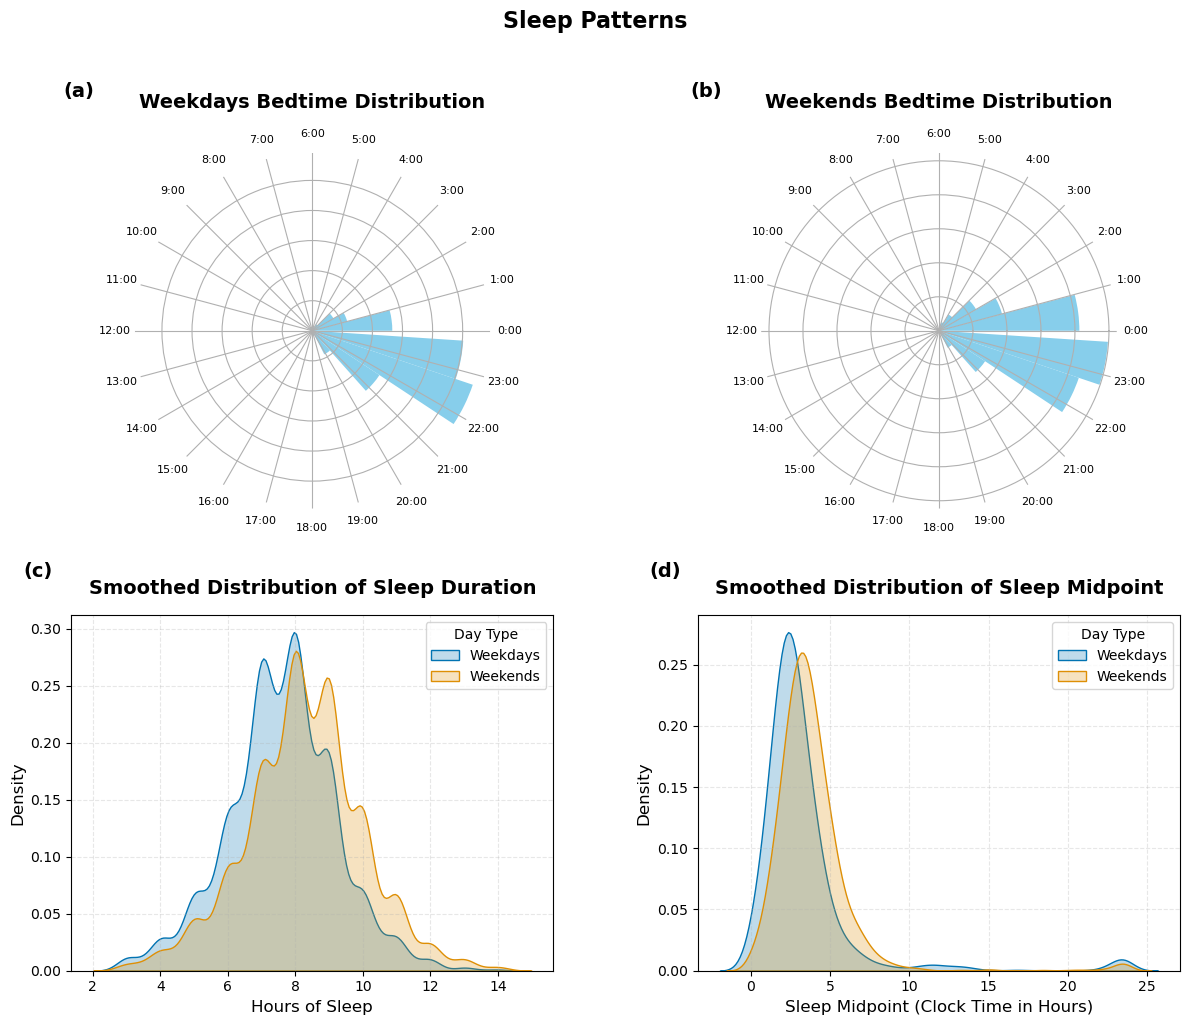

In [46]:
cols = ['Bedtime_weekdays_hrs', 'Bedtime_weekends_hrs']
titles = ['Weekdays Bedtime Distribution', 'Weekends Bedtime Distribution']

cols_hrs = ['Sleep_hrs_weekdays', 'Sleep_hrs_weekends']
titles_hrs = ['Sleep Hours (Weekdays)', 'Sleep Hours (Weekends)']

fig = plt.figure(figsize=(12,10))

# Polar plots
for i in range(2):
    # Create polar axis
    ax = fig.add_subplot(2, 2, i+1, projection='polar', 
                        frame_on=False)    # No frame from start
    
    # Convert hours to angles
    angles = 2 * np.pi * data[cols[i]] / 24
    ax.hist(angles, bins=24, color='skyblue')
    ax.set_title(titles[i], fontsize=14, pad=15, weight='semibold')
    ax.text(-0.2, 1.2, f'({chr(97+i)})', transform=ax.transAxes,
        fontsize=14, fontweight='bold', va='top')
    
    # Set hour labels
    ax.set_yticklabels([])  # cleaner
    ax.set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
    ax.set_xticklabels([f'{h}:00' for h in range(24)], fontsize=8)


# Customized colors
kde_colors = sns.color_palette('colorblind')[:2]

# 'Sleep_hrs_weekdays' and 'Sleep_hrs_weekends'
ax = fig.add_subplot(2, 2, 3)
sns.kdeplot(data['Sleep_hrs_weekdays'].dropna(), label='Weekdays', fill=True, color=kde_colors[0])
sns.kdeplot(data['Sleep_hrs_weekends'].dropna(), label='Weekends', fill=True, color=kde_colors[1])

ax.set_title('Smoothed Distribution of Sleep Duration', fontsize=14, pad=15, weight='semibold')
ax.text(-0.1, 1.15, f'({chr(99)})', transform=ax.transAxes,
        fontsize=14, fontweight='bold', va='top')

ax.set_xlabel('Hours of Sleep', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

ax.legend(title='Day Type')
ax.grid(True, linestyle='--', alpha=0.3)

# 'Sleep_midpoint_weekdays' and 'Sleep_midpoint_weekends' smoothed distribution
ax = fig.add_subplot(2, 2, 4)
sns.kdeplot(data['Sleep_midpoint_weekdays'].dropna(), label='Weekdays', fill=True, color=kde_colors[0])
sns.kdeplot(data['Sleep_midpoint_weekends'].dropna(), label='Weekends', fill=True, color=kde_colors[1])

ax.set_title('Smoothed Distribution of Sleep Midpoint', fontsize=14, pad=15, weight='semibold')
ax.text(-0.1, 1.15, f'({chr(100)})', transform=ax.transAxes,
        fontsize=14, fontweight='bold', va='top')

ax.set_xlabel('Sleep Midpoint (Clock Time in Hours)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

ax.legend(title='Day Type', fontsize=10, title_fontsize=10, loc='upper right')
ax.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Sleep Patterns', y=1.02, fontsize=16, weight='semibold')
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Increase spacing between plots

# Save combined plot
plt.savefig('bedtime_distribution_v3.png', dpi=600, bbox_inches='tight')
plt.show()

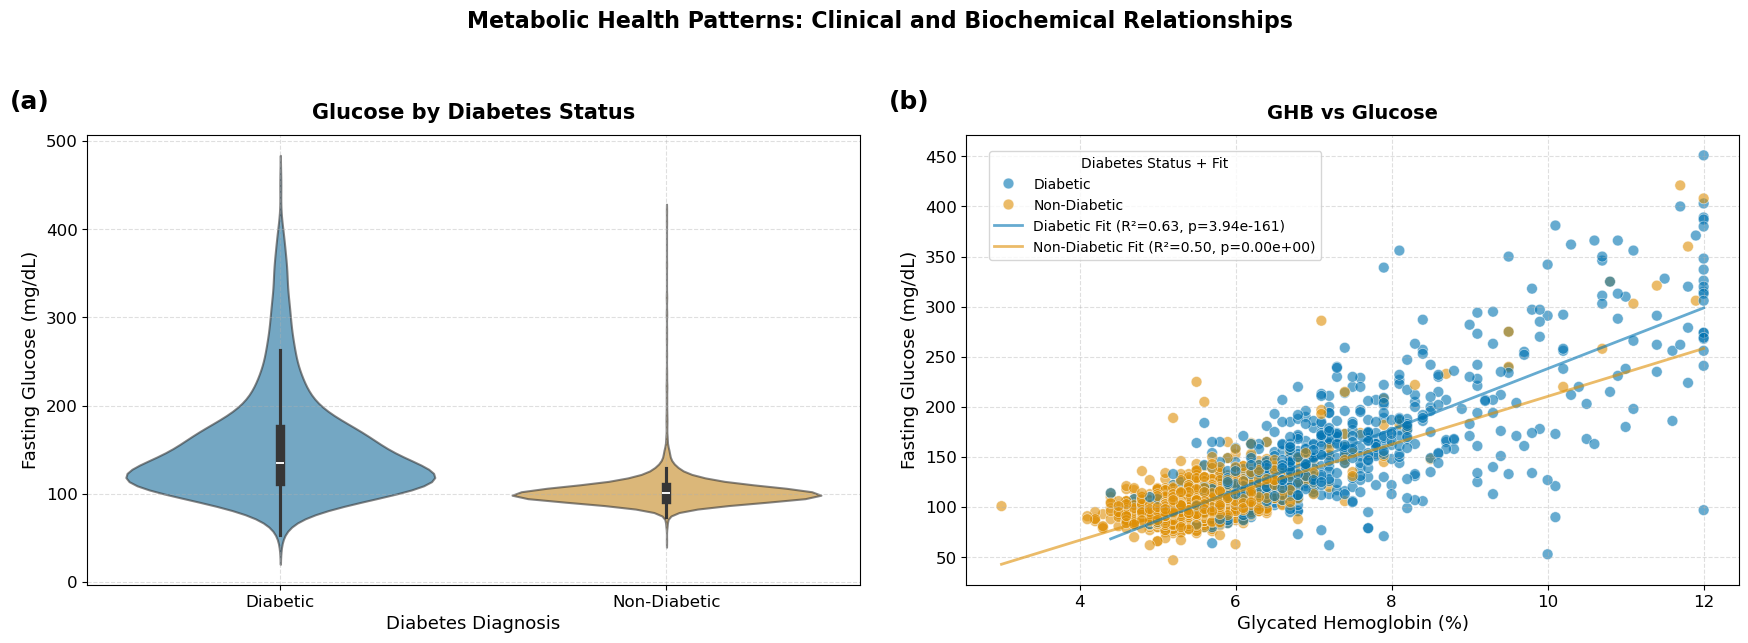

In [50]:
from scipy.stats import linregress

# Define colorblind-safe palette
cb_palette = sns.color_palette('colorblind')
label_order = sorted(data['Diabetes_label'].dropna().unique())
palette_dict = dict(zip(label_order, cb_palette[:len(label_order)]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Violin plot
sns.violinplot(
    ax=ax1,
    x='Diabetes_label', 
    y='Fasting_glucose',
    data=data,
    hue='Diabetes_label',
    palette=palette_dict,
    inner='box',
    linewidth=1.5,
    order=label_order,
    alpha=0.6
)
ax1.set_title('Glucose by Diabetes Status', fontsize=15, pad=12, weight='semibold')
ax1.set_xlabel('Diabetes Diagnosis', fontsize=13)
ax1.set_ylabel('Fasting Glucose (mg/dL)', fontsize=13)
ax1.tick_params(axis='both', labelsize=12)
ax1.grid(True, linestyle='--', alpha=0.4)
if ax1.get_legend():
    ax1.get_legend().remove()
ax1.text(-0.1, 1.1, '(a)', transform=ax1.transAxes,
         fontsize=18, fontweight='bold', va='top', ha='left')

# Scatter Plot 
sns.scatterplot(
    ax=ax2,
    x='GHB',
    y='Fasting_glucose',
    data=data,
    hue='Diabetes_label',
    palette=palette_dict,
    hue_order=label_order,
    s=60,
    edgecolor='w',
    linewidth=0.5,
    alpha=0.6
)

# Add regression lines 
for label in label_order:
    group = data[data['Diabetes_label'] == label]
    x = group['GHB']
    y = group['Fasting_glucose']
    
    # Drop NaNs
    valid = x.notna() & y.notna()
    x = x[valid]
    y = y[valid]
    
    slope, intercept, r, p, _ = linregress(x, y)
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = intercept + slope * x_vals
    ax2.plot(x_vals, y_vals,
             color=palette_dict[label],
             lw=2, linestyle='-', alpha=0.6,
             label=f'{label} Fit (R²={r**2:.2f}, p={p:.2e})')

ax2.set_title('GHB vs Glucose', fontsize=14, pad=12, weight='semibold')
ax2.set_xlabel('Glycated Hemoglobin (%)', fontsize=13)
ax2.set_ylabel('Fasting Glucose (mg/dL)', fontsize=13)
ax2.tick_params(axis='both', labelsize=12)
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend(title='Diabetes Status + Fit', bbox_to_anchor=(0.02, 0.98), loc='upper left')
ax2.text(-0.1, 1.1, '(b)', transform=ax2.transAxes,
         fontsize=18, fontweight='bold', va='top', ha='left')

# Final layout
plt.suptitle('Metabolic Health Patterns: Clinical and Biochemical Relationships', 
             y=0.95, fontsize=16, weight='semibold')
plt.tight_layout(pad=3)
plt.savefig('metabolic_relationships_v3.png', dpi=600, bbox_inches='tight')
plt.show()


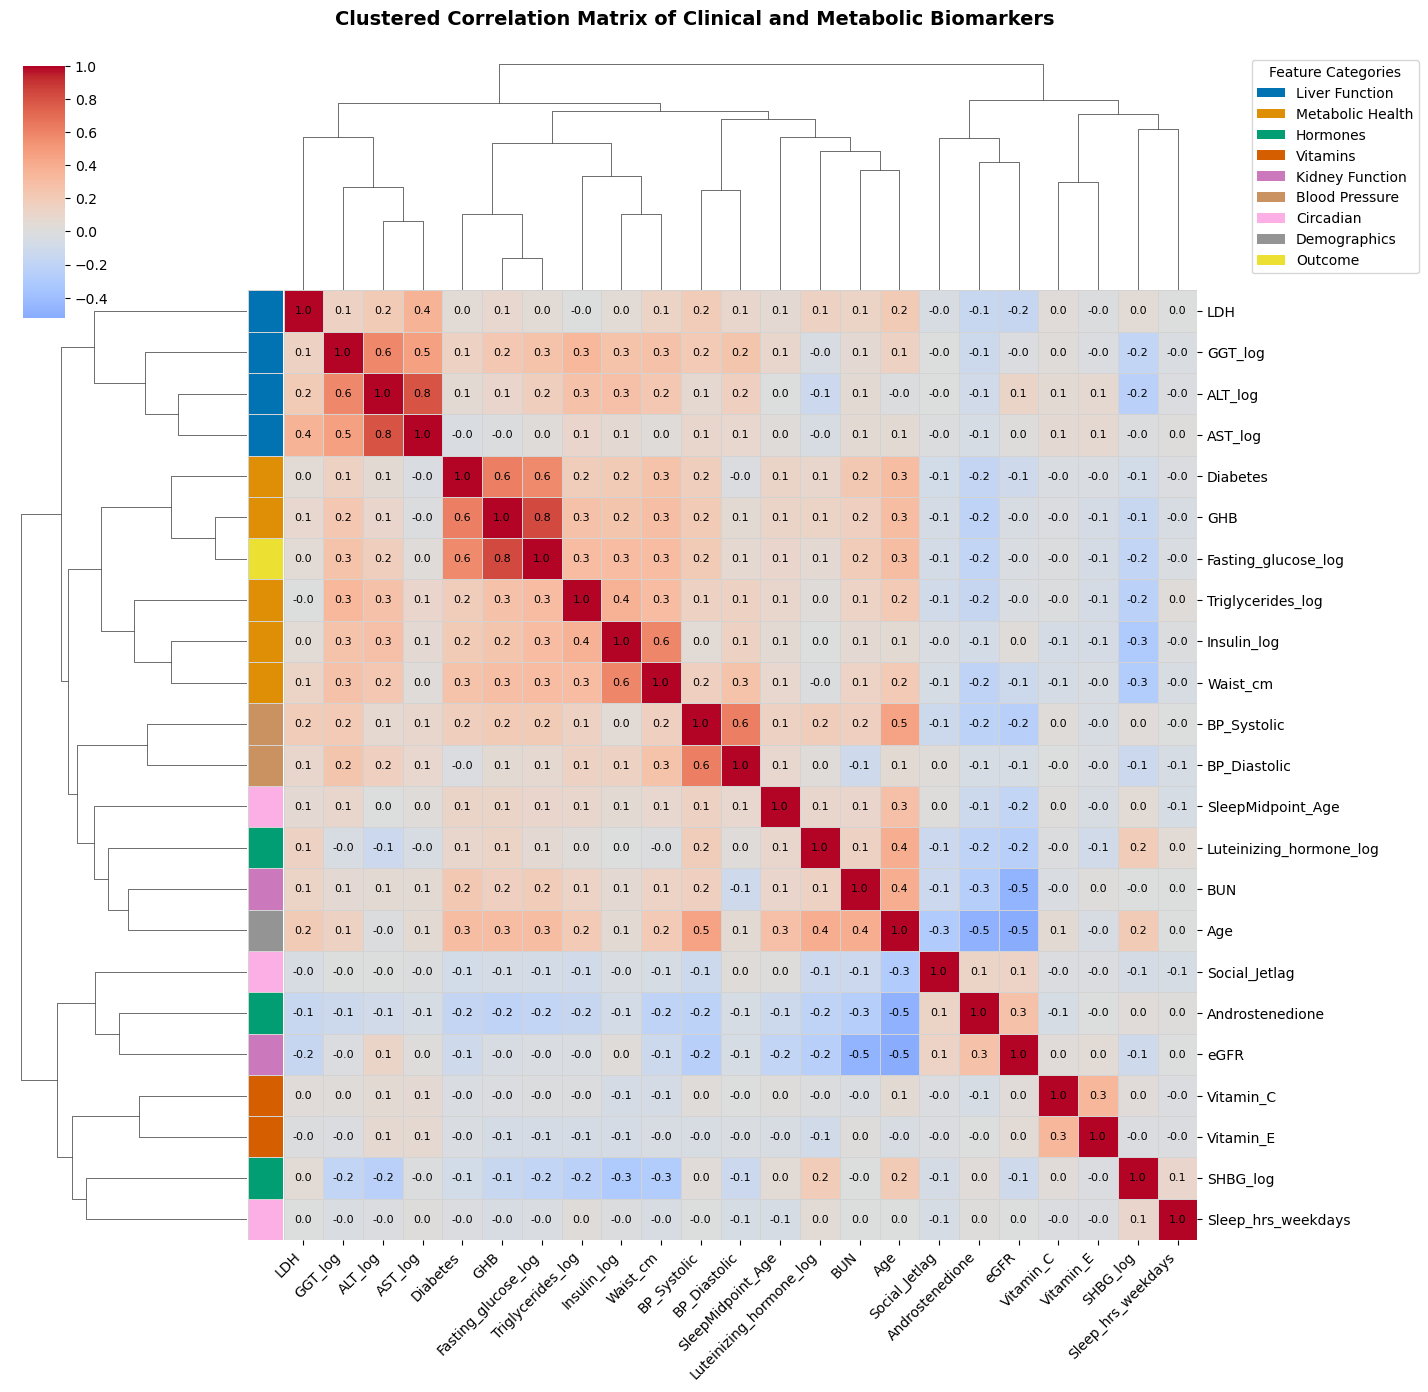

In [59]:
from itertools import cycle
from matplotlib.patches import Patch
from scipy.stats import zscore

data['SleepMidpoint_Age'] = data.Sleep_midpoint_weekends * data.Age

# Define features of interest with clinical groupings
biomarker_groups = {
    'Liver Function': ['GGT_log', 'ALT_log', 'AST_log', 'LDH'],
    'Metabolic Health': ['GHB', 'Insulin_log', 'Triglycerides_log', 'Waist_cm', 'Diabetes'],
    'Hormones': ['SHBG_log', 'Androstenedione', 'Luteinizing_hormone_log'],
    'Vitamins': ['Vitamin_C', 'Vitamin_E'],
    'Kidney Function': ['eGFR', 'BUN'],
    'Blood Pressure': ['BP_Systolic', 'BP_Diastolic'],
    'Circadian': ['SleepMidpoint_Age', 'Social_Jetlag', 'Sleep_hrs_weekdays'],
    'Demographics': ['Age'],
    'Outcome': ['Fasting_glucose_log'] 
}

# Flatten grouped features for selection
plottable = [feat for group in biomarker_groups.values() for feat in group]

# Prepare data matrix with z-score normalization
df_cluster = data[plottable].select_dtypes(include='number').dropna()
# Standardize for comparable color scaling
df_cluster = df_cluster.apply(zscore)  

# Calculate correlations with precision
corr = df_cluster.corr(method='pearson').round(2)

# Create a mapping of feature to group color
group_colors = dict(zip(biomarker_groups.keys(), sns.color_palette('colorblind', n_colors=len(biomarker_groups))))

# Assign each feature the color of its group
row_colors = []
for group_name, features in biomarker_groups.items():
    color = group_colors[group_name]
    for feat in features:
        if feat in corr.columns:
            row_colors.append(color)

# Create clustermap
g = sns.clustermap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=True,
    annot_kws={'size': 8, 'color': 'black'},
    fmt='.1f',
    linewidths=0.5,
    linecolor='lightgray',
    figsize=(14, 14),
    dendrogram_ratio=(0.2, 0.2),
    cbar_pos=(0.02, 0.8, 0.03, 0.18),
    row_colors=row_colors,
)

# Customize xticklabels and yticklabels
g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
g.ax_heatmap.set_yticklabels(
    g.ax_heatmap.get_yticklabels(), 
    rotation=0,
    fontsize=10
)

# Add title
g.fig.suptitle(
    'Clustered Correlation Matrix of Clinical and Metabolic Biomarkers',
    fontsize=14, fontweight='bold', y=1.02
)

# Create legend for clinical groups
handles = [Patch(facecolor=color) 
          for color in sns.color_palette('colorblind', len(biomarker_groups))]

g.ax_heatmap.legend(
    handles, biomarker_groups.keys(),
    bbox_to_anchor=(1.25, 1.25), 
    title='Feature Categories',
    fontsize=10
)

plt.savefig('enhanced_cluster_heatmap_v3.png', dpi=600, bbox_inches='tight')
plt.show()

# Modeling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import uniform, randint
import shap

In [4]:
sns.set_palette('colorblind')

In [30]:
# Load data
data = pd.read_csv('circadian_metabolism_data.csv')

# Drop rows with missing target
data = data.dropna(subset=['Fasting_glucose_log'])

# Age subgroup
age_bins = [18, 35, 60, 100]
age_labels = ['Young (18-35)', 'Middle (35-60)', 'Senior (60+)']
data['Age_Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Map for cleaner layout of diabetes status
data['Diabetes_label'] = data['Diabetes'].map({0: 'Non-Diabetic', 1: 'Diabetic'})

# BMI subgroup
bmi_bins = [0, 25, 30, 100]
bmi_labels = ['Normal', 'Overweight', 'Obese']
data['BMI_Group'] = pd.cut(data['BMI'], bins=bmi_bins, labels=bmi_labels, include_lowest=True)

# Sleep hours category
sleep_hrs_bins = [0, 6.5, 9.5, 24]
sleep_hrs_labels = ['Short_Sleep', 'Optimal_Sleep', 'Long_Sleep']
data['Sleep_hrs_Category'] = pd.cut(data.Sleep_hrs_weekdays, bins=sleep_hrs_bins, labels=sleep_hrs_labels)

# Drop rows with NaNs in stratification variables before splitting
data = data.dropna(subset=['Age_Group'])

# Convert object columns to categorical 
object_cols = data.select_dtypes(include=['object']).columns.tolist()
data[object_cols] = data[object_cols].astype('category')

# Binary categorical features (except Race), do not need OHE
cat_cols_int = ['Smoked', 'Gender', 'Diabetes', 'Diet', 'Weight_loss_diet', 'Low_fat_diet', 'Low_salt_diet', 
                'Sugar_free_diet', 'Low_carbohydrate_diet', 'High_protein_diet', 'Vigorous_work', 
                'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreational'
               ]
# Insure these categorical features are of type in
data[cat_cols_int] = data[cat_cols_int].astype(int)

cat_cols_non_binary = ['Race', 'Cancer_coded', 'Diabetes_family_history_coded']
for col in cat_cols_non_binary:
    data[col] = data[col].astype('category')

# Define variable to use for analysis
metabolic_vars = ['BMI', 'Waist_cm', 'HDL', 'GHB', 'CRP_log', 'ALT_log', 'AST_log', 'GGT_log', 'Uric_acid',
                  'Triglycerides_log', 'LDL', 'eGFR', 'ACR_log', 'Insulin_log',
                  'BP_Systolic', 'BP_Diastolic', 'Fasting_glucose_log', 'BUN', 'LDH', 'Globulin', 
                  'Total_protein', 'Cholesterol_log', 'Creatinine_log'
                 ]

circadian_vars = ['Bedtime_weekdays_hrs_sin', 'Sleep_health', 'Jetlag_hrs', 'Sleep_Apnea_risk',
                  'Sleep_midpoint_weekdays', 'Sleep_midpoint_weekends', 'Sleep_hrs_Category',
                  'Bedtime_SD', 'Sleep_Duration_SD', 'Sleep_hrs_weekdays', 'Sleep_schedule']

lifestyle_vars = ['Vigorous_work', 'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreational',
                  'Diabetes_family_history_coded', 'Cancer_coded', 'Lifestyle_score', 'Sedentary_hrs', 'Smoked',
                 'Activity_category', 'Sedentary_category', 'Lifestyle_category', 'Diabetes']


hormones_vars = [ 'SHBG_log', 'Estradiol_log', 'Androstenedione', 'Luteinizing_hormone_log', 'Follicle_stimulating_hormone_log'] 

nutrients_vars = ['Energy', 'Protein', 'Carbohydrate', 'Dietary_fiber', 
                   'Sodium', 'Potassium', 'Caffeine_log', 'Alcohol_log', 'Total_saturated_fatty_acids_log',
                  'Total_monounsaturated_fatty_acids', 'Total_polyunsaturated_fatty_acids', 'Vitamin_E', 'Vitamin_A_log',
                  'Vitamin_C', 'Vitamin_D', 'Calcium', 'Iron', 'Zinc_log', 'Selenium', 'B1', 'B2', 'Niacin', 'B6', 
                  'Total_folate', 'B12_log', 'Alpha_carotene_log', 'Beta_carotene_log', 'Lycopene_log', 'Lutein_zeaxanthin',
                  'Diet', 'Weight_loss_diet', 'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Low_carbohydrate_diet',
                  'High_protein_diet'
                 ] 

control_vars = ['Gender', 'Age', 'Race', 'Poverty_index']

In [5]:
data_cat = data[cat_cols_int]
for col in cat_cols_int:
    print(f'{col}: {data_cat[col].unique()}')


Smoked: [1 0]
Gender: [1 0]
Diabetes: [0 1]
Diet: [0 1]
Weight_loss_diet: [0 1]
Low_fat_diet: [0 1]
Low_salt_diet: [0 1]
Sugar_free_diet: [0 1]
Low_carbohydrate_diet: [0 1]
High_protein_diet: [0 1]
Vigorous_work: [0 1]
Moderate_work: [1 0]
Walk_or_bicycle: [0 1]
Vigorous_recreational: [0 1]
Moderate_recreational: [0 1]


### Remove highly correlated features

In [31]:
numerical_vars = metabolic_vars + circadian_vars + lifestyle_vars + hormones_vars + nutrients_vars
numerical_data = data[numerical_vars].select_dtypes(include=['number']).drop(columns=['Fasting_glucose_log'])

# Compute correlation matrix
corr_matrix = numerical_data.corr().abs()

# Select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find highly correlated pairs
high_corr_pairs = [(col, idx, upper.loc[col, idx]) 
                   for col in upper.columns for idx in upper.index 
                   if upper.loc[col, idx] > 0.85]

# Convert to DataFrame for better visualization
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Features to drop from each pair
features_to_drop = list(set(high_corr_df['Feature 1'].values))
features_to_drop

['Jetlag_hrs',
 'Luteinizing_hormone_log',
 'Energy',
 'BMI',
 'Protein',
 'Niacin',
 'LDL']

In [56]:
#!pip install prettytable

# Table for model comparison
from prettytable import PrettyTable

# Create a table instance
table = PrettyTable()

# Create headers
table.field_names = ['Model', 'MAE', 'R^2 (Train)', 'R^2 (Test)', 'R^2 (Cross-validated)', 'R^2 (Nested CV)', 'Features']
print(table) 

+-------+-----+-------------+------------+-----------------------+-----------------+----------+
| Model | MAE | R^2 (Train) | R^2 (Test) | R^2 (Cross-validated) | R^2 (Nested CV) | Features |
+-------+-----+-------------+------------+-----------------------+-----------------+----------+
+-------+-----+-------------+------------+-----------------------+-----------------+----------+


In [9]:
def evaluate_model_with_subgroup_analysis(model, model_name, X_train, y_train, X_test, y_test,
                                          feature_names, table, nested_cv_best_score, subgroup_data=None):
    '''
    Evaluates regression model, adds results to the comparison table and returns comprehensive metrics.

    Parameters:
    - model: fitted regression model pipeline (with preprocessor inside)
    - model_name: string for model identification in table
    - X_train, y_train: training data (untransformed)
    - X_test, y_test: test data (untransformed)
    - feature_names: list of feature names (should correspond to model's transformed features)
    - table: PrettyTable instance for logging summary results
    - nested_cv_best_score: best score from nested CV to add to the table results
    - subgroup_data: dict of subgroup_name: subgroup_labels (on test set indices)

    Returns:
    dict with keys:
      - MAE, R^2 (train/test/cv), Permutation Importance DataFrame,
      - Subgroup Metrics (per subgroup), Calibration Slope & Intercept
    '''
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Main metrics
    mae = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # Cross-validated R2 on training set (5-fold)
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    # Compute permutation importance
    r = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)    
    perm_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': r.importances_mean,
        'importance_std': r.importances_std
    }).sort_values(by='importance_mean', ascending=False)

    # Append summary to table
    table.add_row([model_name, round(mae, 4), round(r2_train, 4), round(r2_test, 4),
                   f'{cv_mean:.3f} ± {cv_std:.3f}', round(nested_cv_best_score, 4), len(feature_names)])

    # Calibration regression: fit predicted vs observed on test
    calib_lr = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_test)
    calib_slope, calib_intercept = calib_lr.coef_[0], calib_lr.intercept_

    # Subgroup evaluation on test set
    y_pred_test = pd.Series(y_pred_test, index=y_test.index)
    subgroup_metrics = {}
    if subgroup_data is not None:
        for subgroup_name, labels in subgroup_data.items():
            subgroup_metrics[subgroup_name] = {}

            # Ensure label Series is aligned with y_test
            labels = pd.Series(labels, index=y_test.index)
            unique_labels = np.unique(labels)
            
            for label in unique_labels:
                idx = labels[labels == label].index
                if len(idx) < 10:
                    continue
                r2_sub = r2_score(y_test.loc[idx], y_pred_test[idx])
                mae_sub = mean_absolute_error(y_test.loc[idx], y_pred_test[idx])
                
                subgroup_metrics[subgroup_name][label] = {'R2': round(r2_sub, 4), 'MAE': round(mae_sub, 4)}
    

    return {
        'MAE': round(mae, 4),
        'R^2 (Train)': round(r2_train, 4),
        'R^2 (Test)': round(r2_test, 4),
        'R^2 (K-Fold validated)': f"{cv_mean:.3f} ± {cv_std:.3f}",
        'Permutation Importance': perm_importance_df,
        'Subgroup Metrics': subgroup_metrics,
        'Calibration Slope': round(calib_slope, 4),
        'Calibration Intercept': round(calib_intercept, 4)
    }


In [10]:
def clean_feature_name(name):
    """Handle transformed feature names with underscores"""
    prefix, col = name.split('__', 1)
    if prefix == 'cat':
        col_name, suffix = col.rsplit('_', 1)
        return col_name if col_name in binary_cols else col
    return col

In [11]:
def save_subgroup_metrics_to_csv(subgroup_metrics, filename):
    """Save subgroup metrics to CSV"""
    rows = []
    for group, metrics_dict in subgroup_metrics.items():
        for label, metrics in metrics_dict.items():
            rows.append({
                'Subgroup': group,
                'Label': label,
                'R2': metrics['R2'],
                'MAE': metrics['MAE']
            })
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f'Subgroup metrics saved to {filename}')

In [12]:
def print_subgroup_report(subgroup_metrics):
    for group, metrics_dict in subgroup_metrics.items():
        print(f'\nSubgroup: {group}')
        print(f'{'Label':<20} {'R2':>8} {'MAE':>10}')
        print('-' * 40)
        for label, metrics in metrics_dict.items():
            print(f'{str(label):<20} {metrics['R2']:8.3f} {metrics['MAE']:10.3f}')

In [13]:
def print_calibration_report(calib_slope, calib_intercept):
    print('\nCalibration Metrics:')
    print(f'Calibration Slope     : {calib_slope:.4f}  (ideal ~ 1.0)')
    print(f'Calibration Intercept : {calib_intercept:.4f} (ideal ~ 0.0)')


In [14]:
def plot_calibration(y_true, y_pred, model_name='Model'):
    """Plot calibration curve (observed vs predicted)"""
    # Create figure
    plt.figure(figsize=(6, 6))
    
    # Scatter plot of predicted vs observed
    plt.scatter(y_pred, y_true, 
                alpha=0.4, 
                edgecolor='k', 
                linewidth=0.3, 
                color=sns.color_palette('colorblind')[0],
                label='Predictions')

    # Plot perfect calibration line
    min_val = min(min(y_pred), min(y_true))
    max_val = max(max(y_pred), max(y_true))
    plt.plot([min_val, max_val], [min_val, max_val], 
             'k--', 
             label='Perfect Calibration')

    # Axis labels with units if applicable
    plt.xlabel('Predicted Glucose (mg/dL)', fontsize=12)
    plt.ylabel('Observed Glucose (mg/dL)', fontsize=12)

    # Title
    plt.title(f'Calibration Plot: {model_name}', fontsize=14, weight='semibold')

    # Axes and grid
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.legend()
    plt.axis('equal') 

    # Layout and save
    plt.tight_layout()
    plt.savefig(f'calibration_curve_{model_name.replace(" ", "_").lower()}.png', 
                dpi=600, 
                bbox_inches='tight',
                transparent=False)
    plt.show()


### Data Pipeline

In [32]:
# Select features and target
X = data[control_vars + circadian_vars + metabolic_vars + hormones_vars + nutrients_vars + lifestyle_vars]
# Drop highly correlated features and target
X = X.drop(columns=['Fasting_glucose_log'] + features_to_drop)
y = data.Fasting_glucose_log

# Split into train, validation, and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=data['Age_Group'], random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=data.loc[X_train_val.index, 'Age_Group'], random_state=0
)

# Align y_test index with X_test
y_test = pd.Series(y_test.values, index=X_test.index)

# Define numerical and categorical columns
cat_cols = X.select_dtypes(include='category').columns.tolist()
binary_cols = [col for col in X.columns 
               if np.isin(X[col].dropna().unique(), [0, 1]).all() 
               and col not in cat_cols]
num_cols = X.select_dtypes(include='number').columns.tolist()
num_cols = list(set(num_cols) - set(binary_cols))
all_cat_cols = cat_cols + binary_cols 

# Define preprocessing pipeline
numerical_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=10)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, num_cols),
    ('cat', categorical_transformer, all_cat_cols)
], remainder='drop')

# Subgroup data
subgroup_data = {
    'Diabetes_status': data.loc[X_test.index, 'Diabetes'],
    'Age_group': data.loc[X_test.index, 'Age_Group']
}

In [16]:
binary_cols

['Gender',
 'Diet',
 'Weight_loss_diet',
 'Low_fat_diet',
 'Low_salt_diet',
 'Sugar_free_diet',
 'Low_carbohydrate_diet',
 'High_protein_diet',
 'Vigorous_work',
 'Moderate_work',
 'Walk_or_bicycle',
 'Vigorous_recreational',
 'Moderate_recreational',
 'Smoked',
 'Diabetes']

In [17]:
X.shape

(4016, 85)

In [35]:
X_train.shape

(2409, 85)

In [36]:
X_val.shape

(803, 85)

In [37]:
X_test.shape

(804, 85)

In [18]:
X.Gender.value_counts()

Gender
0    2070
1    1946
Name: count, dtype: int64

In [19]:
# Check the distribution of age in test set after splitting
test_age_distribution = data.loc[X_test.index, 'Age_Group'].value_counts()
print('Test Set Age Groups:\n', test_age_distribution)

Test Set Age Groups:
 Age_Group
Middle (35-60)    323
Senior (60+)      262
Young (18-35)     219
Name: count, dtype: int64


### Summary table

In [33]:
from scipy.stats import kruskal, chi2_contingency

metabolic_vars_original = [
    'BMI', 'Waist_cm', 'HDL', 'GHB', 'CRP', 'ALT', 'AST', 'GGT', 'Uric_acid',
    'Triglycerides', 'LDL', 'eGFR', 'ACR', 'Insulin',
    'BP_Systolic', 'BP_Diastolic', 'Fasting_glucose', 'BUN', 'LDH', 'Globulin',
    'Total_protein', 'Cholesterol', 'Creatinine'
                 ]
circadian_vars_original = [
    'Bedtime_weekdays_hrs', 'Jetlag_hrs',
    'Sleep_midpoint_weekdays', 'Sleep_midpoint_weekends', 'Sleep_hrs_Category',
    'Sleep_hrs_weekdays', 'Sleep_schedule'
]
lifestyle_vars_original = [
    'Vigorous_work', 'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreational',
    'Diabetes_family_history', 'Cancer', 'Sedentary_hrs', 'Smoked',
    'Activity_category', 'Sedentary_category', 'Lifestyle_category', 'Diabetes'
]
hormones_vars_original = [ 'SHBG', 'Estradiol', 'Androstenedione', 'Luteinizing_hormone', 'Follicle_stimulating_hormone']
nutrients_vars_original = [
    'Energy', 'Protein', 'Carbohydrate', 'Dietary_fiber',
    'Sodium', 'Potassium', 'Caffeine', 'Alcohol', 'Total_saturated_fatty_acids',
    'Total_monounsaturated_fatty_acids', 'Total_polyunsaturated_fatty_acids', 'Vitamin_E', 'Vitamin_A',
    'Vitamin_C', 'Vitamin_D', 'Calcium', 'Iron', 'Zinc', 'Selenium', 'B1', 'B2', 'Niacin', 'B6', 
    'Total_folate', 'B12', 'Alpha_carotene', 'Beta_carotene', 'Lycopene', 'Lutein_zeaxanthin',
    'Diet', 'Weight_loss_diet', 'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Low_carbohydrate_diet',
    'High_protein_diet'
                 ] 
control_vars = ['Gender', 'Age', 'Race', 'Poverty_index']
all_vars = (
    control_vars + metabolic_vars_original + circadian_vars_original + lifestyle_vars_original + hormones_vars_original + nutrients_vars_original
)

# Copy data and assign dataset split labels
df_final = data[all_vars].copy()
df_final['set'] = 'unassigned'
df_final.loc[X_train.index, 'set'] = 'train'
df_final.loc[X_val.index, 'set'] = 'val'
df_final.loc[X_test.index, 'set'] = 'test'


cat_cols = [
    'Smoked', 'Race', 'Gender', 'Cancer', 'Diabetes_family_history', 'Diabetes', 'Diet', 'Weight_loss_diet',
    'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Low_carbohydrate_diet', 'High_protein_diet',
    'Vigorous_work', 'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreational',
    'Activity_category', 'Sedentary_category', 'Lifestyle_category', 'Sleep_hrs_Category', 'Sleep_schedule'
               ]

summary_data_expanded = []

for var in all_vars:
    if var in cat_cols:
        try:
            contingency = pd.crosstab(df_final[var], df_final.set)
            _, p, _, _ = chi2_contingency(contingency)
            p_value = f'{p:.3f}'
        except:
            p_value = 'NA'
        
        # For categorical variables: expand each category as a separate row
        categories = df_final[var].dropna().unique()
        categories.sort() if hasattr(categories, 'sort') else None
        
        for cat in categories:
            row = {'Variable': var, 'Category': cat}
            cat_counts = {}
            for group in ['train', 'val', 'test']:
                counts = df_final[df_final.set == group][var].value_counts(dropna=False)
                count = counts.get(cat, 0)
                total = counts.sum()
                pct = 100 * count / total if total > 0 else 0
                cat_counts[group] = f'{count} ({pct:.1f}%)'
            
            row.update(cat_counts)
            row['p'] = p_value
            summary_data_expanded.append(row)
            
    else:
        # Continuous vars 
        try:
            row = {'Variable': var, 'Category': ''}
            for group in ['train', 'val', 'test']:
                subset = df_final[df_final.set == group][var].dropna()
                q1 = subset.quantile(0.25)
                q2 = subset.median()
                q3 = subset.quantile(0.75)
                row[group] = f'{q2:.2f} ({q1:.2f}, {q3:.2f})'

            data_groups = [df_final[df_final.set == g][var].dropna() for g in ['train', 'val', 'test']]
            _, p = kruskal(*data_groups)
            row['p'] = f'{p:.3f}'
            summary_data_expanded.append(row)
        except:
            summary_data_expanded.append({'Variable': var, 'Category': '', 'train': 'Error', 'val': 'Error', 'test': 'Error', 'p': 'NA'})

summary_df_expanded = pd.DataFrame(summary_data_expanded)


In [34]:
summary_df_expanded

Variable Category                 train  \
0                   Gender        0          1220 (50.6%)   
1                   Gender        1          1189 (49.4%)   
2                      Age           51.00 (34.00, 64.00)   
3                     Race      3.0           830 (34.5%)   
4                     Race      7.0            130 (5.4%)   
..                     ...      ...                   ...   
119        Sugar_free_diet        1             18 (0.7%)   
120  Low_carbohydrate_diet        0          2373 (98.5%)   
121  Low_carbohydrate_diet        1             36 (1.5%)   
122      High_protein_diet        0          2403 (99.8%)   
123      High_protein_diet        1              6 (0.2%)   

                      val                  test      p  
0             408 (50.8%)           442 (55.0%)  0.093  
1             395 (49.2%)           362 (45.0%)  0.093  
2    49.00 (34.00, 65.00)  51.00 (34.00, 64.00)  0.988  
3             255 (31.8%)           290 (36.1%)  0.032  
4               47 (5.9%)             37 (4.6%)  0.032  
..                    ...                   ...    ...  
119              8 (1.0%)              8 (1.0%)  0.702  
120           786 (97.9%)           792 (98.5%)  0.457  
121             17 (2.1%)             12 (1.5%)  0.457  
122           799 (99.5%)           802 (99.8%)  0.512  
123              4 (0.5%)              2 (0.2%)  0.512  

[124 rows x 6 columns]

In [41]:
summary_df_expanded.to_clipboard(index=False)

## 1. Baseline Regression Model: Elastic Net Model

ElasticNet model has been chosen due to its ability to handle multicollinearity well

Nested CV best parameters: {'regressor__alpha': 0.07203605819788694, 'regressor__l1_ratio': 0.08712929970154071}
+----------------------+--------+-------------+------------+-----------------------+-----------------+----------+
|        Model         |  MAE   | R^2 (Train) | R^2 (Test) | R^2 (Cross-validated) | R^2 (Nested CV) | Features |
+----------------------+--------+-------------+------------+-----------------------+-----------------+----------+
| 1. ElasticNet (Full) | 0.0883 |    0.679    |   0.7433   |     0.672 ± 0.037     |      0.672      |    85    |
+----------------------+--------+-------------+------------+-----------------------+-----------------+----------+
                    feature  importance_mean  importance_std
16                      GHB         1.031615        0.028060
25              Insulin_log         0.012728        0.000972
84                 Diabetes         0.009532        0.000814
1                       Age         0.006876        0.001225
20          

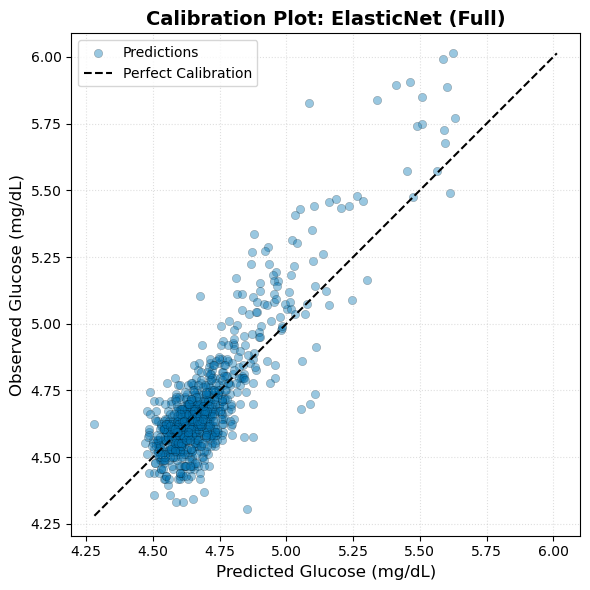

In [67]:
# Define pipeline with preprocessor and ElasticNet
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])

# Define param grid 
param_distributions = {
    'regressor__alpha': uniform(0.001, 1),
    'regressor__l1_ratio': uniform(0, 1),
}

# RandomizedSearchCV with pipeline
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

nested_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=outer_cv,
    scoring='r2',
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    random_state=0
)

# Fit on training data
nested_search.fit(X_train_val, y_train_val)
best_model = nested_search.best_estimator_
best_params = nested_search.best_params_
print('Nested CV best parameters:', best_params)

preproc = best_model.named_steps['preprocessor']

# Evaluate the final model
results = evaluate_model_with_subgroup_analysis(
    best_model,
    '1. ElasticNet (Full)',
    X_train_val,
    y_train_val,
    X_test,
    y_test,
    X_test.columns,
    table,
    nested_search.best_score_,
    subgroup_data=subgroup_data
)

# Print results
print(table)
print(results['Permutation Importance'])
print_subgroup_report(results['Subgroup Metrics'])
print_calibration_report(results['Calibration Slope'], results['Calibration Intercept'])

# Plot calibration curve using actual preds (assuming you have y_pred_test from model.predict)
plot_calibration(y_test, best_model.predict(X_test), model_name='ElasticNet (Full)')


## 2. XGBoost Model 

### 1. XGBoost model with full features

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Nested CV best parameters: {'regressor__subsample': 0.7, 'regressor__reg_lambda': 15, 'regressor__reg_alpha': 0.2, 'regressor__n_estimators': 1000, 'regressor__min_child_weight': 12, 'regressor__max_depth': 2, 'regressor__learning_rate': 0.02, 'regressor__gamma': 0.05, 'regressor__colsample_bytree': 0.8}
+----------------------+--------+-------------+------------+-----------------------+-----------------+----------+
|        Model         |  MAE   | R^2 (Train) | R^2 (Test) | R^2 (Cross-validated) | R^2 (Nested CV) | Features |
+----------------------+--------+-------------+------------+-----------------------+-----------------+----------+
| 1. ElasticNet (Full) | 0.0883 |    0.679    |   0.7433   |     0.672 ± 0.037     |      0.672      |    85    |
|  2. XGBoost (Full)   | 0.0801 |    0.7821   |   0.7808   |     0.700 ± 0.041     |      0.7012     |    85    |
+----------------------+--------+-------------+------------+--

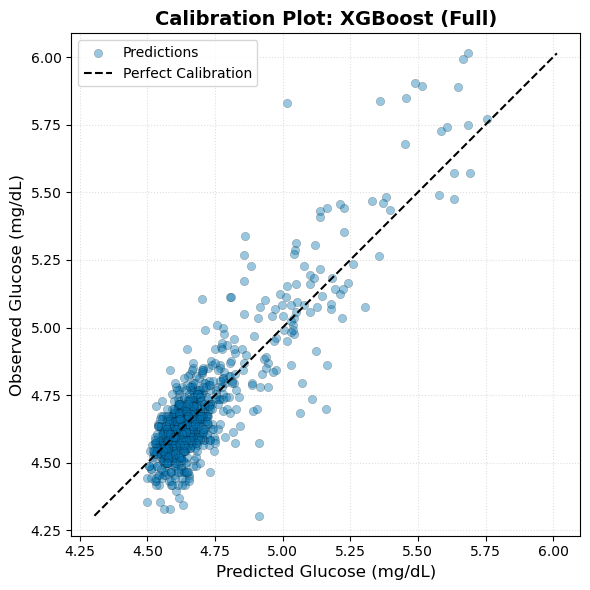

Subgroup metrics saved to subgroup_metrics_xgb.csv


 97%|=================== | 3114/3212 [00:26<00:00]       

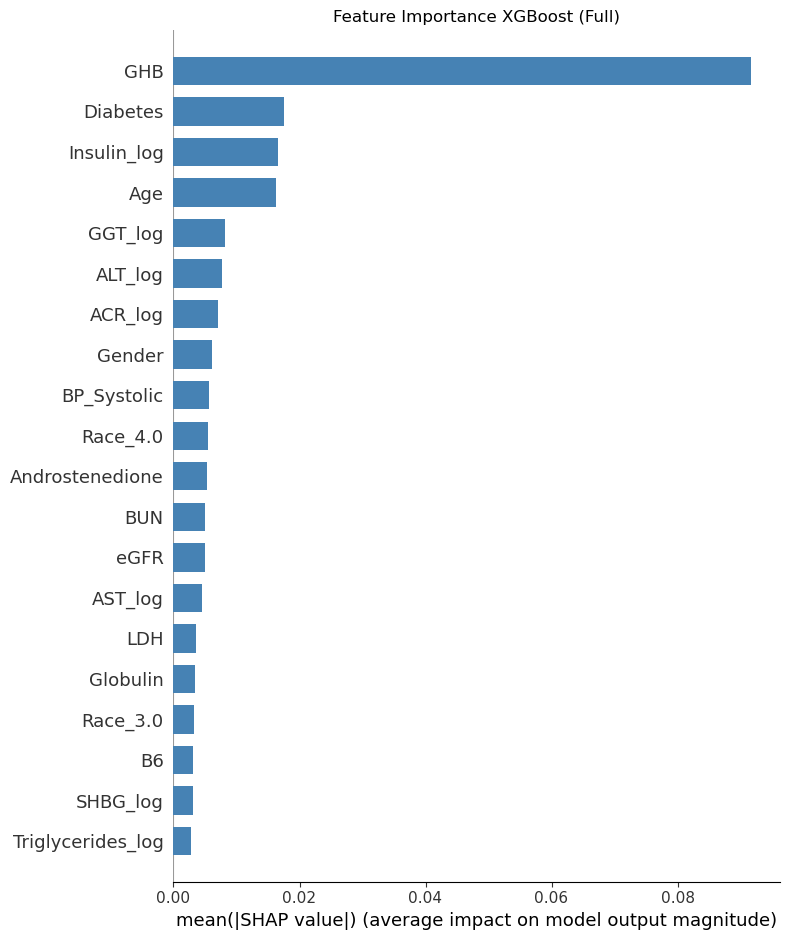

In [68]:
# Define pipeline with preprocessor and XGBRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(enable_categorical=False, random_state=0))
])

# Define param grid 
param_distributions_xgb = {
    'regressor__n_estimators': [1000, 1200, 1500],
    'regressor__learning_rate': [0.01, 0.015, 0.02],
    'regressor__max_depth': [2, 3],
    'regressor__min_child_weight': [10, 12, 15],
    'regressor__subsample': [0.7, 0.8],
    'regressor__colsample_bytree': [0.7, 0.8],
    'regressor__reg_alpha': [0.1, 0.2],
    'regressor__reg_lambda': [10, 15, 20],
    'regressor__gamma': [0.05, 0.1]
}

# RandomizedSearchCV with pipeline
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

nested_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions_xgb,
    n_iter=50,
    cv=outer_cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=0
)

# Fit on training data
nested_search.fit(X_train_val, y_train_val)
best_model = nested_search.best_estimator_
print('Nested CV best parameters:', nested_search.best_params_)

# Evaluate the final model
results = evaluate_model_with_subgroup_analysis(
    best_model,
    '2. XGBoost (Full)',
    X_train_val,
    y_train_val,
    X_test,
    y_test,
    X_test.columns,
    table,
    nested_search.best_score_,
    subgroup_data=subgroup_data
)

# Print results
print(table)
print(results['Permutation Importance'])
print_subgroup_report(results['Subgroup Metrics'])
print_calibration_report(results['Calibration Slope'], results['Calibration Intercept'])

# Plot calibration curve using actual preds (assuming you have y_pred_test from model.predict)
plot_calibration(y_test, best_model.predict(X_test), model_name='XGBoost (Full)')

# Save subgroup metrics
save_subgroup_metrics_to_csv(results['Subgroup Metrics'], 'subgroup_metrics_xgb.csv')

# SHAP Analysis
preproc = best_model.named_steps['preprocessor']
X_train_trans = preproc.transform(X_train_val)
explainer = shap.Explainer(best_model.named_steps['regressor'], X_train_trans) 
shap_values = explainer(X_train_trans)

feature_names = preproc.get_feature_names_out()
feature_names_cleaned = [clean_feature_name(name) for name in feature_names]

# SHAP summary plot
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values,
                  X_train_trans,
                  feature_names=feature_names_cleaned,
                  plot_type='bar',
                  color='steelblue',
                  show=False)
plt.title('Feature Importance XGBoost (Full)')
plt.tight_layout()
plt.show()



### 2. Feature Selection 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Nested CV best parameters: {'regressor__subsample': 0.7, 'regressor__reg_lambda': 10, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 1500, 'regressor__min_child_weight': 12, 'regressor__max_depth': 2, 'regressor__learning_rate': 0.015, 'regressor__gamma': 0.05, 'regressor__colsample_bytree': 0.7}
+-----------------------+--------+-------------+------------+-----------------------+-----------------+----------+
|         Model         |  MAE   | R^2 (Train) | R^2 (Test) | R^2 (Cross-validated) | R^2 (Nested CV) | Features |
+-----------------------+--------+-------------+------------+-----------------------+-----------------+----------+
|  1. ElasticNet (Full) | 0.0883 |    0.679    |   0.7433   |     0.672 ± 0.037     |      0.672      |    85    |
|   2. XGBoost (Full)   | 0.0801 |    0.7821   |   0.7808   |     0.700 ± 0.041     |      0.7012     |    85    |
| 3. XGBoost (Selected) | 0.0816 |    0.7628   |   0.761

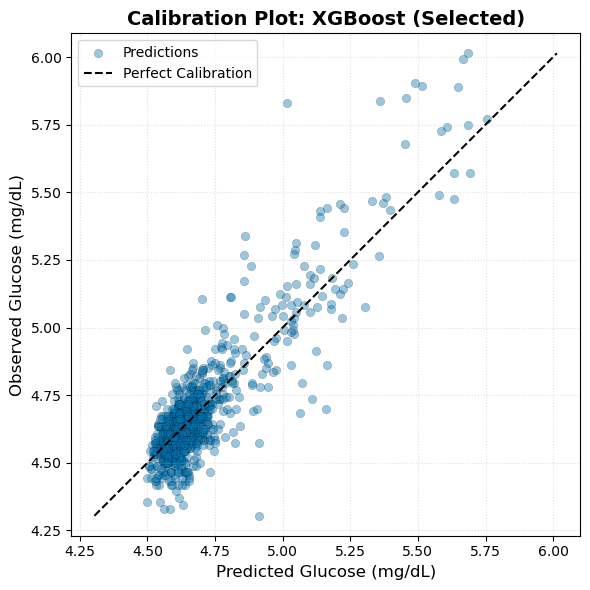

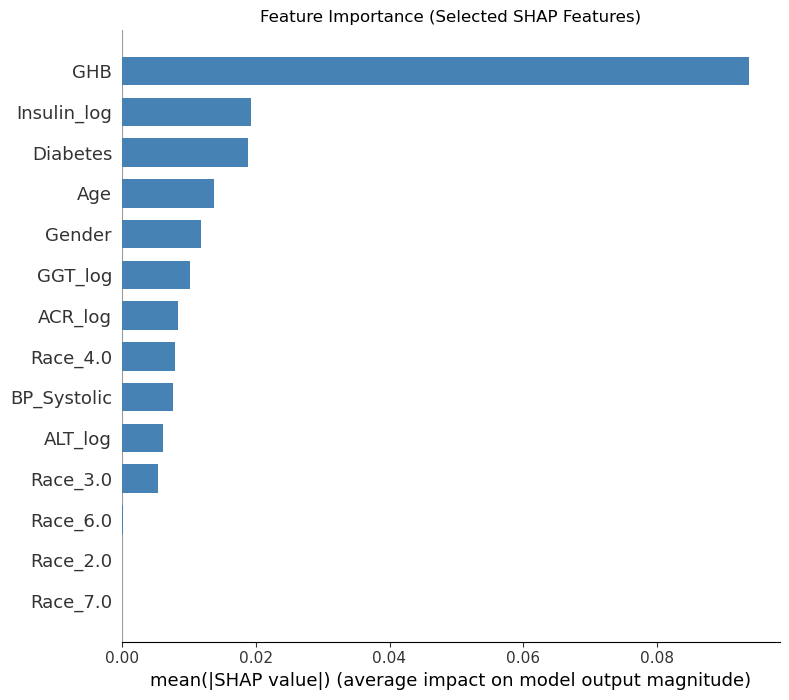

In [69]:
# Aggregate SHAP values by original features (handling one-hot encoded features)
feature_importance = pd.DataFrame(index=X_train_val.columns)
feature_importance['shap_abs'] = 0.

# For numerical features
for col in num_cols:
    col_idx = np.where(feature_names == f'num__{col}')[0]
    if len(col_idx) > 0:
        feature_importance.loc[col, 'shap_abs'] = np.abs(shap_values.values[:, col_idx]).mean()

# For categorical features
for col in all_cat_cols:
    # Get all one-hot encoded columns for this categorical feature
    pattern = f'cat__{col}_'
    col_idxs = [i for i, name in enumerate(feature_names) if name.startswith(pattern)]
    if col_idxs:
        feature_importance.loc[col, 'shap_abs'] = np.abs(shap_values.values[:, col_idxs]).sum(axis=1).mean()

# Select top N features
top_features = feature_importance.nlargest(10, 'shap_abs').index.tolist()
# Remove features with negative and very small permutation importance
# Comment this line on the first run
#top_features = list(set(top_features) - set(['BP_Systolic', 'ACR_log']))

# Define new preprocessor only for top features
preprocessor_top = ColumnTransformer([
    ('num', numerical_transformer, list(set(top_features) & set(num_cols))),
    ('cat', categorical_transformer, list(set(top_features) & set(all_cat_cols)))
], remainder='drop')

# New pipeline with feature selection
pipeline_top = Pipeline([
    ('preprocessor', preprocessor_top),
    ('regressor', XGBRegressor(enable_categorical=False, random_state=0))
])

# Nested CV with reduced feature set
nested_search_top = RandomizedSearchCV(
    estimator=pipeline_top,
    param_distributions=param_distributions_xgb,
    n_iter=50,
    cv=outer_cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=0
)

# Fit nested search on reduced training data
nested_search_top.fit(X_train_val[top_features], y_train_val)
best_model_top = nested_search_top.best_estimator_
print('Nested CV best parameters:', nested_search_top.best_params_)

# Evaluate the final model
results = evaluate_model_with_subgroup_analysis(
    best_model_top,
    '3. XGBoost (Selected)',
    X_train_val[top_features],
    y_train_val,
    X_test[top_features],
    y_test,
    top_features,
    table,
    nested_search_top.best_score_,
    subgroup_data=subgroup_data
)

# Print results
print(table)
print(results['Permutation Importance'])
print_subgroup_report(results['Subgroup Metrics'])
print_calibration_report(results['Calibration Slope'], results['Calibration Intercept'])

# Plot calibration curve using actual preds (assuming you have y_pred_test from model.predict)
plot_calibration(y_test, best_model.predict(X_test), model_name='XGBoost (Selected)')

# SHAP Analysis
preproc_top = best_model_top.named_steps['preprocessor']
X_train_top_trans = preproc_top.transform(X_train_val[top_features])
X_test_top_trans = preproc_top.transform(X_test[top_features])
explainer_top = shap.Explainer(best_model_top.named_steps['regressor'], X_train_top_trans)
shap_values_top = explainer_top(X_test_top_trans)

feature_names_top = preproc_top.get_feature_names_out()
feature_names_top_cleaned = [clean_feature_name(name) for name in feature_names_top]

# SHAP summary plot
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values_top,
                  X_train_top_trans,
                  feature_names=feature_names_top_cleaned,
                  plot_type='bar',
                  color='steelblue',
                  show=False)
plt.title('Feature Importance (Selected SHAP Features)')
plt.tight_layout()
plt.show()


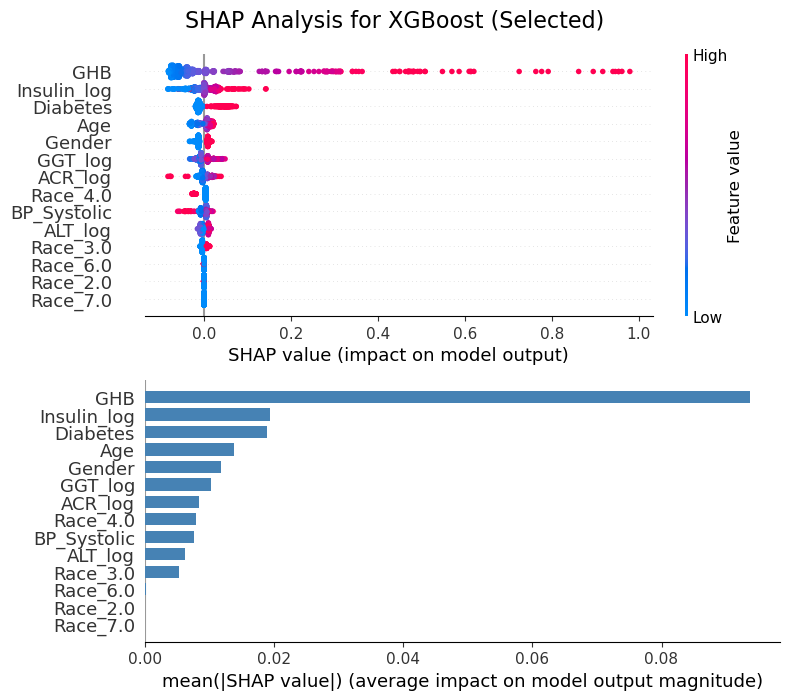

In [70]:
# Create figure and subplots
fig, ax = plt.subplots(2, figsize=(10,10))

# SHAP baeswarm plot
plt.sca(ax[0])
shap.summary_plot(shap_values_top,
                  X_test_top_trans,
                  feature_names=feature_names_top_cleaned, 
                  show=False) 

# SHAP bar plot
plt.sca(ax[1])
shap.summary_plot(shap_values_top,
                  X_test_top_trans,
                  feature_names=feature_names_top_cleaned, 
                  plot_type='bar',
                  color='steelblue',
                  show=False) 

plt.suptitle('SHAP Analysis for XGBoost (Selected)', fontsize=16)

plt.savefig('SHAP_xgboost_selected_v4.png', dpi=600, bbox_inches='tight')
plt.tight_layout()



### 3. Feature Engineering

In [71]:
# Create interaction terms

data['Weekend_Flag'] = (data.Sleep_midpoint_weekends - data.Sleep_midpoint_weekdays).astype(int)
data['Circadian_Disruption'] = abs(data.Sleep_midpoint_weekends - data.Sleep_midpoint_weekdays)
data['Sleep_hrs_avg'] = (data.Sleep_hrs_weekdays * 5 + data.Sleep_hrs_weekends * 2) / 7

data['Sleep_hrs_avg_Insulin'] = data.Sleep_hrs_avg * data.Insulin_log
data['Sleep_hrs_Age'] = data.Sleep_hrs_weekdays * data.Age

data['Bedtime_weekdays_Age'] = data.Bedtime_weekdays_hrs_sin * data.Age
data['Disruption_GHB'] = data.Circadian_Disruption * data.GHB
data['Circadian_Disruption_Age'] = data.Circadian_Disruption * data.Age
data['Waist_cm_Jetlag'] = data.Waist_cm * data.Jetlag_hrs

data['SleepMidpoint_Insulin'] = data.Sleep_midpoint_weekends * data.Insulin_log
data['SleepMidpoint_Age'] = data.Sleep_midpoint_weekends * data.Age
data['SocialJetlag_Age'] = data.Jetlag_hrs * data.Age

metabolic_vars = ['BMI', 'Waist_cm', 'HDL', 'GHB', 'CRP_log', 'ALT_log', 'AST_log', 'GGT_log', 'Uric_acid',
                  'Triglycerides_log', 'LDL', 'eGFR', 'ACR_log', 'Insulin_log',
                  'BP_Systolic', 'BP_Diastolic', 'Fasting_glucose_log', 'BUN', 'LDH', 'Globulin', 
                  'Total_protein', 'Cholesterol', 'Creatinine_log',
                 ]

circadian_vars = ['Bedtime_weekdays_hrs_sin', 'Sleep_health', 'Jetlag_hrs', 'Sleep_Apnea_risk',
                  'Sleep_midpoint_weekdays', 'Sleep_midpoint_weekends',
                  'Bedtime_SD', 'Sleep_Duration_SD', 'Sleep_hrs_weekdays', 'Sleep_schedule', 'Sleep_hrs_Category',
                  'Weekend_Flag', 'Circadian_Disruption', 'SleepMidpoint_Insulin', 'Disruption_GHB', 'Bedtime_weekdays_Age', 'Waist_cm_Jetlag',
                  'SleepMidpoint_Age', 'Sleep_hrs_avg', 'Sleep_hrs_avg_Insulin', 'Sleep_hrs_Age', 'SocialJetlag_Age', 'Circadian_Disruption_Age'
                 ]


### Remove highly correlated features

In [72]:
numerical_vars = metabolic_vars + circadian_vars + lifestyle_vars + hormones_vars + nutrients_vars
numerical_data = data[numerical_vars].select_dtypes(include=['number']).drop(columns=['Fasting_glucose_log'])

# Compute correlation matrix
corr_matrix = numerical_data.corr().abs()

# Select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find highly correlated pairs
high_corr_pairs = [(col, idx, upper.loc[col, idx]) 
                   for col in upper.columns for idx in upper.index 
                   if upper.loc[col, idx] > 0.85]

# Convert to DataFrame for better visualization
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
#print(high_corr_df.sort_values(by='Correlation', ascending=False))

# Features to drop from each pair
features_to_drop = list(set(high_corr_df['Feature 1'].values))
features_to_drop

['Luteinizing_hormone_log',
 'Waist_cm_Jetlag',
 'Sleep_hrs_weekdays',
 'Niacin',
 'Protein',
 'Sleep_midpoint_weekends',
 'Bedtime_weekdays_hrs_sin',
 'Jetlag_hrs',
 'LDL',
 'Energy',
 'BMI',
 'Sleep_health',
 'Circadian_Disruption',
 'Disruption_GHB']

### 4. Data pipeline

In [73]:
# Select features and target
X = data[control_vars + circadian_vars + metabolic_vars + hormones_vars + nutrients_vars + lifestyle_vars]
# Drop highly correlated features and target
X = X.drop(columns=['Fasting_glucose_log'] + features_to_drop)
y = data.Fasting_glucose_log

# Split into train, validation, and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=data['Age_Group'], random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=data.loc[X_train_val.index, 'Age_Group'], random_state=0
)

# Align y_test index with X_test
y_test = pd.Series(y_test.values, index=X_test.index)

# Define numerical and categorical columns
cat_cols = X.select_dtypes(include='category').columns.tolist()
binary_cols = [col for col in X.columns 
               if np.isin(X[col].dropna().unique(), [0, 1]).all() 
               and col not in cat_cols]
num_cols = X.select_dtypes(include='number').columns.tolist()
num_cols = list(set(num_cols) - set(binary_cols))
all_cat_cols = cat_cols + binary_cols 

# Define preprocessing pipeline
numerical_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=10)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, num_cols),
    ('cat', categorical_transformer, all_cat_cols)
], remainder='drop')

# Subgroup data
subgroup_data = {
    'Diabetes_status': data.loc[X_test.index, 'Diabetes'],
    'Age_group': data.loc[X_test.index, 'Age_Group']
}


In [102]:
X.shape

(4016, 90)

### 5. Retraining model with interaction features

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Nested CV best parameters: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 15, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 1200, 'regressor__min_child_weight': 15, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0.05, 'regressor__colsample_bytree': 0.7}
+-----------------------------+--------+-------------+------------+-----------------------+-----------------+----------+
|            Model            |  MAE   | R^2 (Train) | R^2 (Test) | R^2 (Cross-validated) | R^2 (Nested CV) | Features |
+-----------------------------+--------+-------------+------------+-----------------------+-----------------+----------+
|     1. ElasticNet (Full)    | 0.0883 |    0.679    |   0.7433   |     0.672 ± 0.037     |      0.672      |    85    |
|      2. XGBoost (Full)      | 0.0801 |    0.7821   |   0.7808   |     0.700 ± 0.041     |      0.7012     |    85    |
|    3. XGBoost (Selected) 

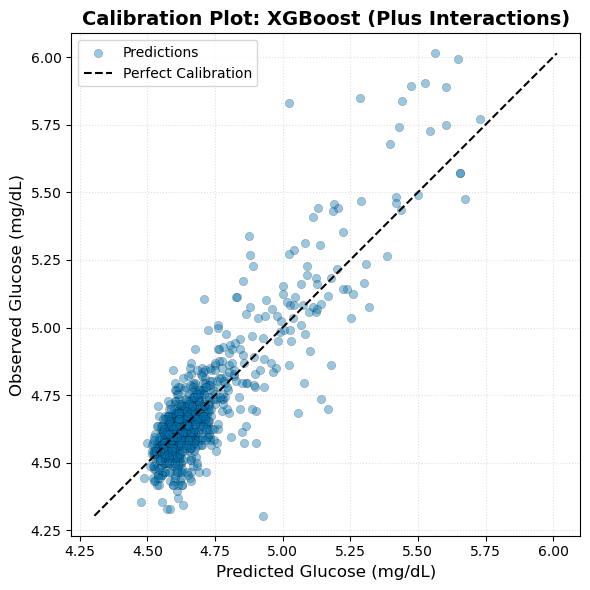

Subgroup metrics saved to subgroup_metrics_xgb.csv


100%|===================| 3206/3212 [00:56<00:00]        

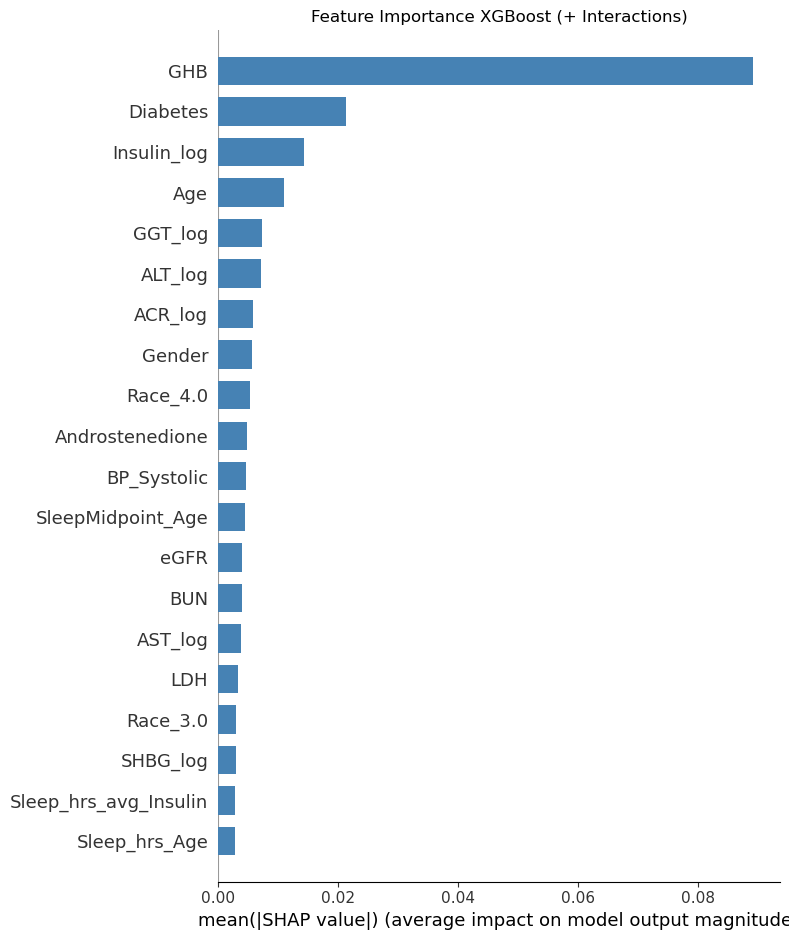

In [74]:
# Define pipeline with preprocessor and XGBRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(enable_categorical=False, random_state=0))
])

# Define param grid 
param_distributions_xgb = {
    'regressor__n_estimators': [1000, 1200, 1500],
    'regressor__learning_rate': [0.01, 0.015, 0.02],
    'regressor__max_depth': [2, 3],
    'regressor__min_child_weight': [10, 12, 15],
    'regressor__subsample': [0.7, 0.8],
    'regressor__colsample_bytree': [0.7, 0.8],
    'regressor__reg_alpha': [0.1, 0.2],
    'regressor__reg_lambda': [10, 15, 20],
    'regressor__gamma': [0.05, 0.1]
}

# RandomizedSearchCV with pipeline
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

nested_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions_xgb,
    n_iter=50,
    cv=outer_cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=0
)

# Fit on training data
nested_search.fit(X_train_val, y_train_val)
best_model = nested_search.best_estimator_
print('Nested CV best parameters:', nested_search.best_params_)

# Evaluate the final model
results = evaluate_model_with_subgroup_analysis(
    best_model,
    '4. XGBoost (+ Interactions)',
    X_train_val,
    y_train_val,
    X_test,
    y_test,
    X_test.columns,
    table,
    nested_search.best_score_,
    subgroup_data=subgroup_data
)

# Print results
print(table)
print(results['Permutation Importance'])
print_subgroup_report(results['Subgroup Metrics'])
print_calibration_report(results['Calibration Slope'], results['Calibration Intercept'])

# Plot calibration curve using actual preds (assuming you have y_pred_test from model.predict)
plot_calibration(y_test, best_model.predict(X_test), model_name='XGBoost (Plus Interactions)')

# Save subgroup metrics
save_subgroup_metrics_to_csv(results['Subgroup Metrics'], 'subgroup_metrics_xgb.csv')

# SHAP Analysis
preproc = best_model.named_steps['preprocessor']
X_train_trans = preproc.transform(X_train_val)
explainer = shap.Explainer(best_model.named_steps['regressor'], X_train_trans) 
shap_values = explainer(X_train_trans)

feature_names = preproc.get_feature_names_out()
feature_names_cleaned = [clean_feature_name(name) for name in feature_names]

# SHAP summary plot
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values,
                  X_train_trans,
                  feature_names=feature_names_cleaned,
                  plot_type='bar',
                  color='steelblue',
                  show=False)
plt.title('Feature Importance XGBoost (+ Interactions)')
plt.tight_layout()
plt.show()

### 6. Feature Selection 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Nested CV best parameters: {'regressor__subsample': 0.7, 'regressor__reg_lambda': 10, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 1000, 'regressor__min_child_weight': 12, 'regressor__max_depth': 2, 'regressor__learning_rate': 0.02, 'regressor__gamma': 0.05, 'regressor__colsample_bytree': 0.8}
+-----------------------------+--------+-------------+------------+-----------------------+-----------------+----------+
|            Model            |  MAE   | R^2 (Train) | R^2 (Test) | R^2 (Cross-validated) | R^2 (Nested CV) | Features |
+-----------------------------+--------+-------------+------------+-----------------------+-----------------+----------+
|     1. ElasticNet (Full)    | 0.0883 |    0.679    |   0.7433   |     0.672 ± 0.037     |      0.672      |    85    |
|      2. XGBoost (Full)      | 0.0801 |    0.7821   |   0.7808   |     0.700 ± 0.041     |      0.7012     |    85    |
|    3. XGBoost (Selected) 

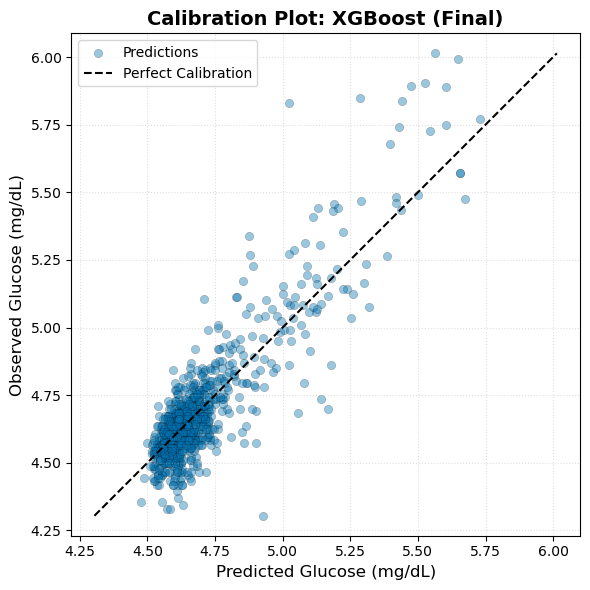

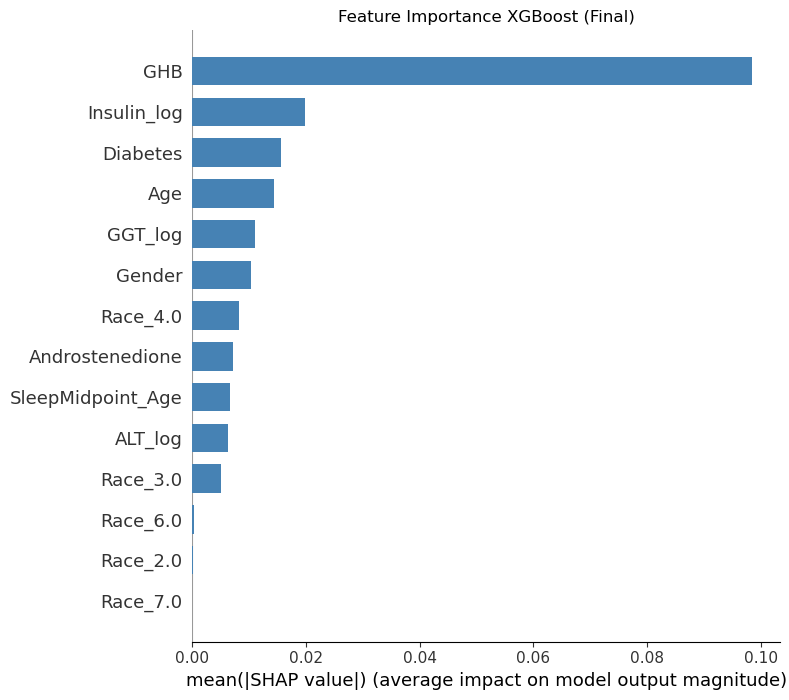

In [76]:
# Aggregate SHAP values by original features (handling one-hot encoded features)
feature_importance = pd.DataFrame(index=X_train_val.columns)
feature_importance['shap_abs'] = 0.

# For numerical features
for col in num_cols:
    col_idx = np.where(feature_names == f'num__{col}')[0]
    if len(col_idx) > 0:
        feature_importance.loc[col, 'shap_abs'] = np.abs(shap_values.values[:, col_idx]).mean()

# For categorical features
for col in all_cat_cols:
    # Get all one-hot encoded columns for this categorical feature
    pattern = f'cat__{col}_'
    col_idxs = [i for i, name in enumerate(feature_names) if name.startswith(pattern)]
    if col_idxs:
        feature_importance.loc[col, 'shap_abs'] = np.abs(shap_values.values[:, col_idxs]).sum(axis=1).mean()

# Select top N features
top_features = feature_importance.nlargest(12, 'shap_abs').index.tolist()
# Remove features with negative and very small permutation importance (comment on the first run)
top_features = list(set(top_features) - set(['ACR_log', 'BP_Systolic']))

# Define new preprocessor only for top features
preprocessor_top = ColumnTransformer([
    ('num', numerical_transformer, list(set(top_features) & set(num_cols))),
    ('cat', categorical_transformer, list(set(top_features) & set(all_cat_cols)))
], remainder='drop')

# New pipeline with feature selection
pipeline_top = Pipeline([
    ('preprocessor', preprocessor_top),
    ('regressor', XGBRegressor(enable_categorical=False, random_state=0))
])

# Nested CV with reduced feature set
nested_search_top = RandomizedSearchCV(
    estimator=pipeline_top,
    param_distributions=param_distributions_xgb,
    n_iter=50,
    cv=outer_cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=0
)

# Fit nested search on reduced training data
nested_search_top.fit(X_train_val[top_features], y_train_val)
best_model_top = nested_search_top.best_estimator_
print('Nested CV best parameters:', nested_search_top.best_params_)

# Evaluate the final model
results = evaluate_model_with_subgroup_analysis(
    best_model_top,
    '5-1. XGBoost (Final)',
    X_train_val[top_features],
    y_train_val,
    X_test[top_features],
    y_test,
    top_features,
    table,
    nested_search_top.best_score_,
    subgroup_data=subgroup_data
)

# Print results
print(table)
print(results['Permutation Importance'])
print_subgroup_report(results['Subgroup Metrics'])
print_calibration_report(results['Calibration Slope'], results['Calibration Intercept'])

# Plot calibration curve using actual preds (assuming you have y_pred_test from model.predict)
plot_calibration(y_test, best_model.predict(X_test), model_name='XGBoost (Final)')

# SHAP Analysis
preproc_top = best_model_top.named_steps['preprocessor']
X_train_top_trans = preproc_top.transform(X_train_val[top_features])
X_test_top_trans = preproc_top.transform(X_test[top_features])
explainer_top = shap.Explainer(best_model_top.named_steps['regressor'], X_train_top_trans)
shap_values_top = explainer_top(X_test_top_trans)

feature_names_top = preproc_top.get_feature_names_out()
feature_names_top_cleaned = [clean_feature_name(name) for name in feature_names_top]

# SHAP summary plot
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values_top,
                  X_train_top_trans,
                  feature_names=feature_names_top_cleaned,
                  plot_type='bar',
                  color='steelblue',
                  show=False)
plt.title('Feature Importance XGBoost (Final)')
plt.tight_layout()
plt.show()


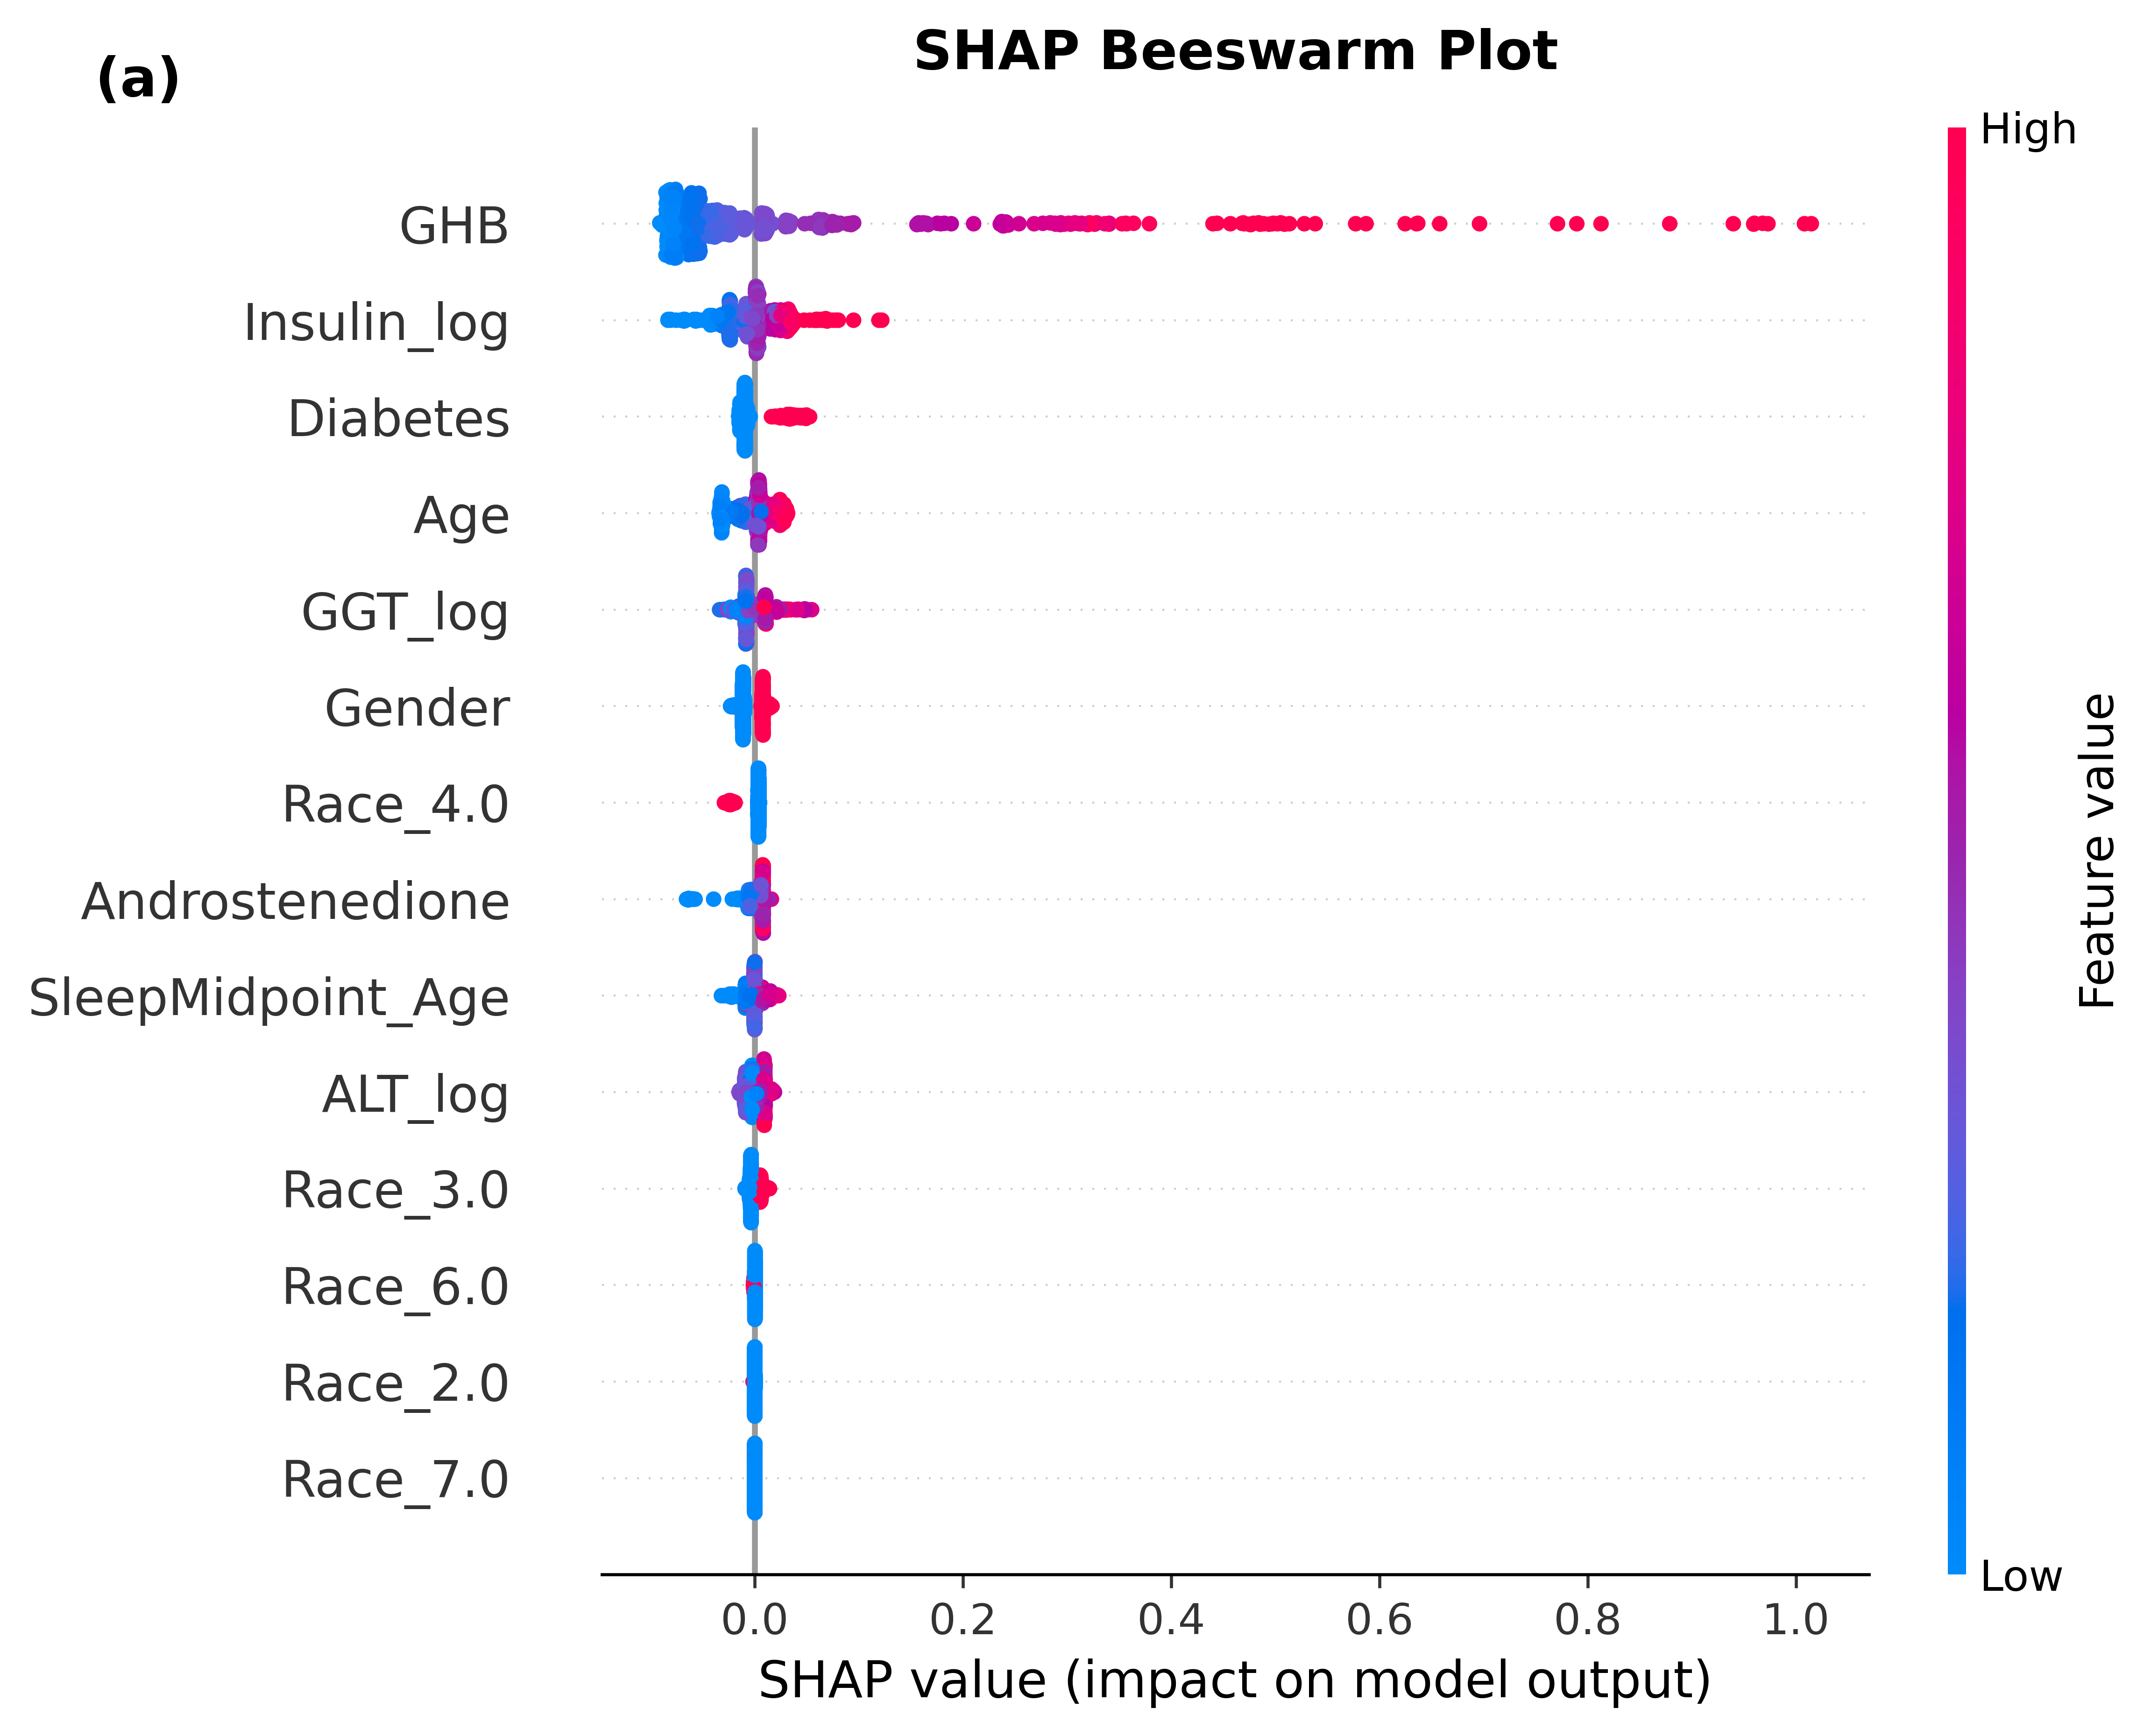

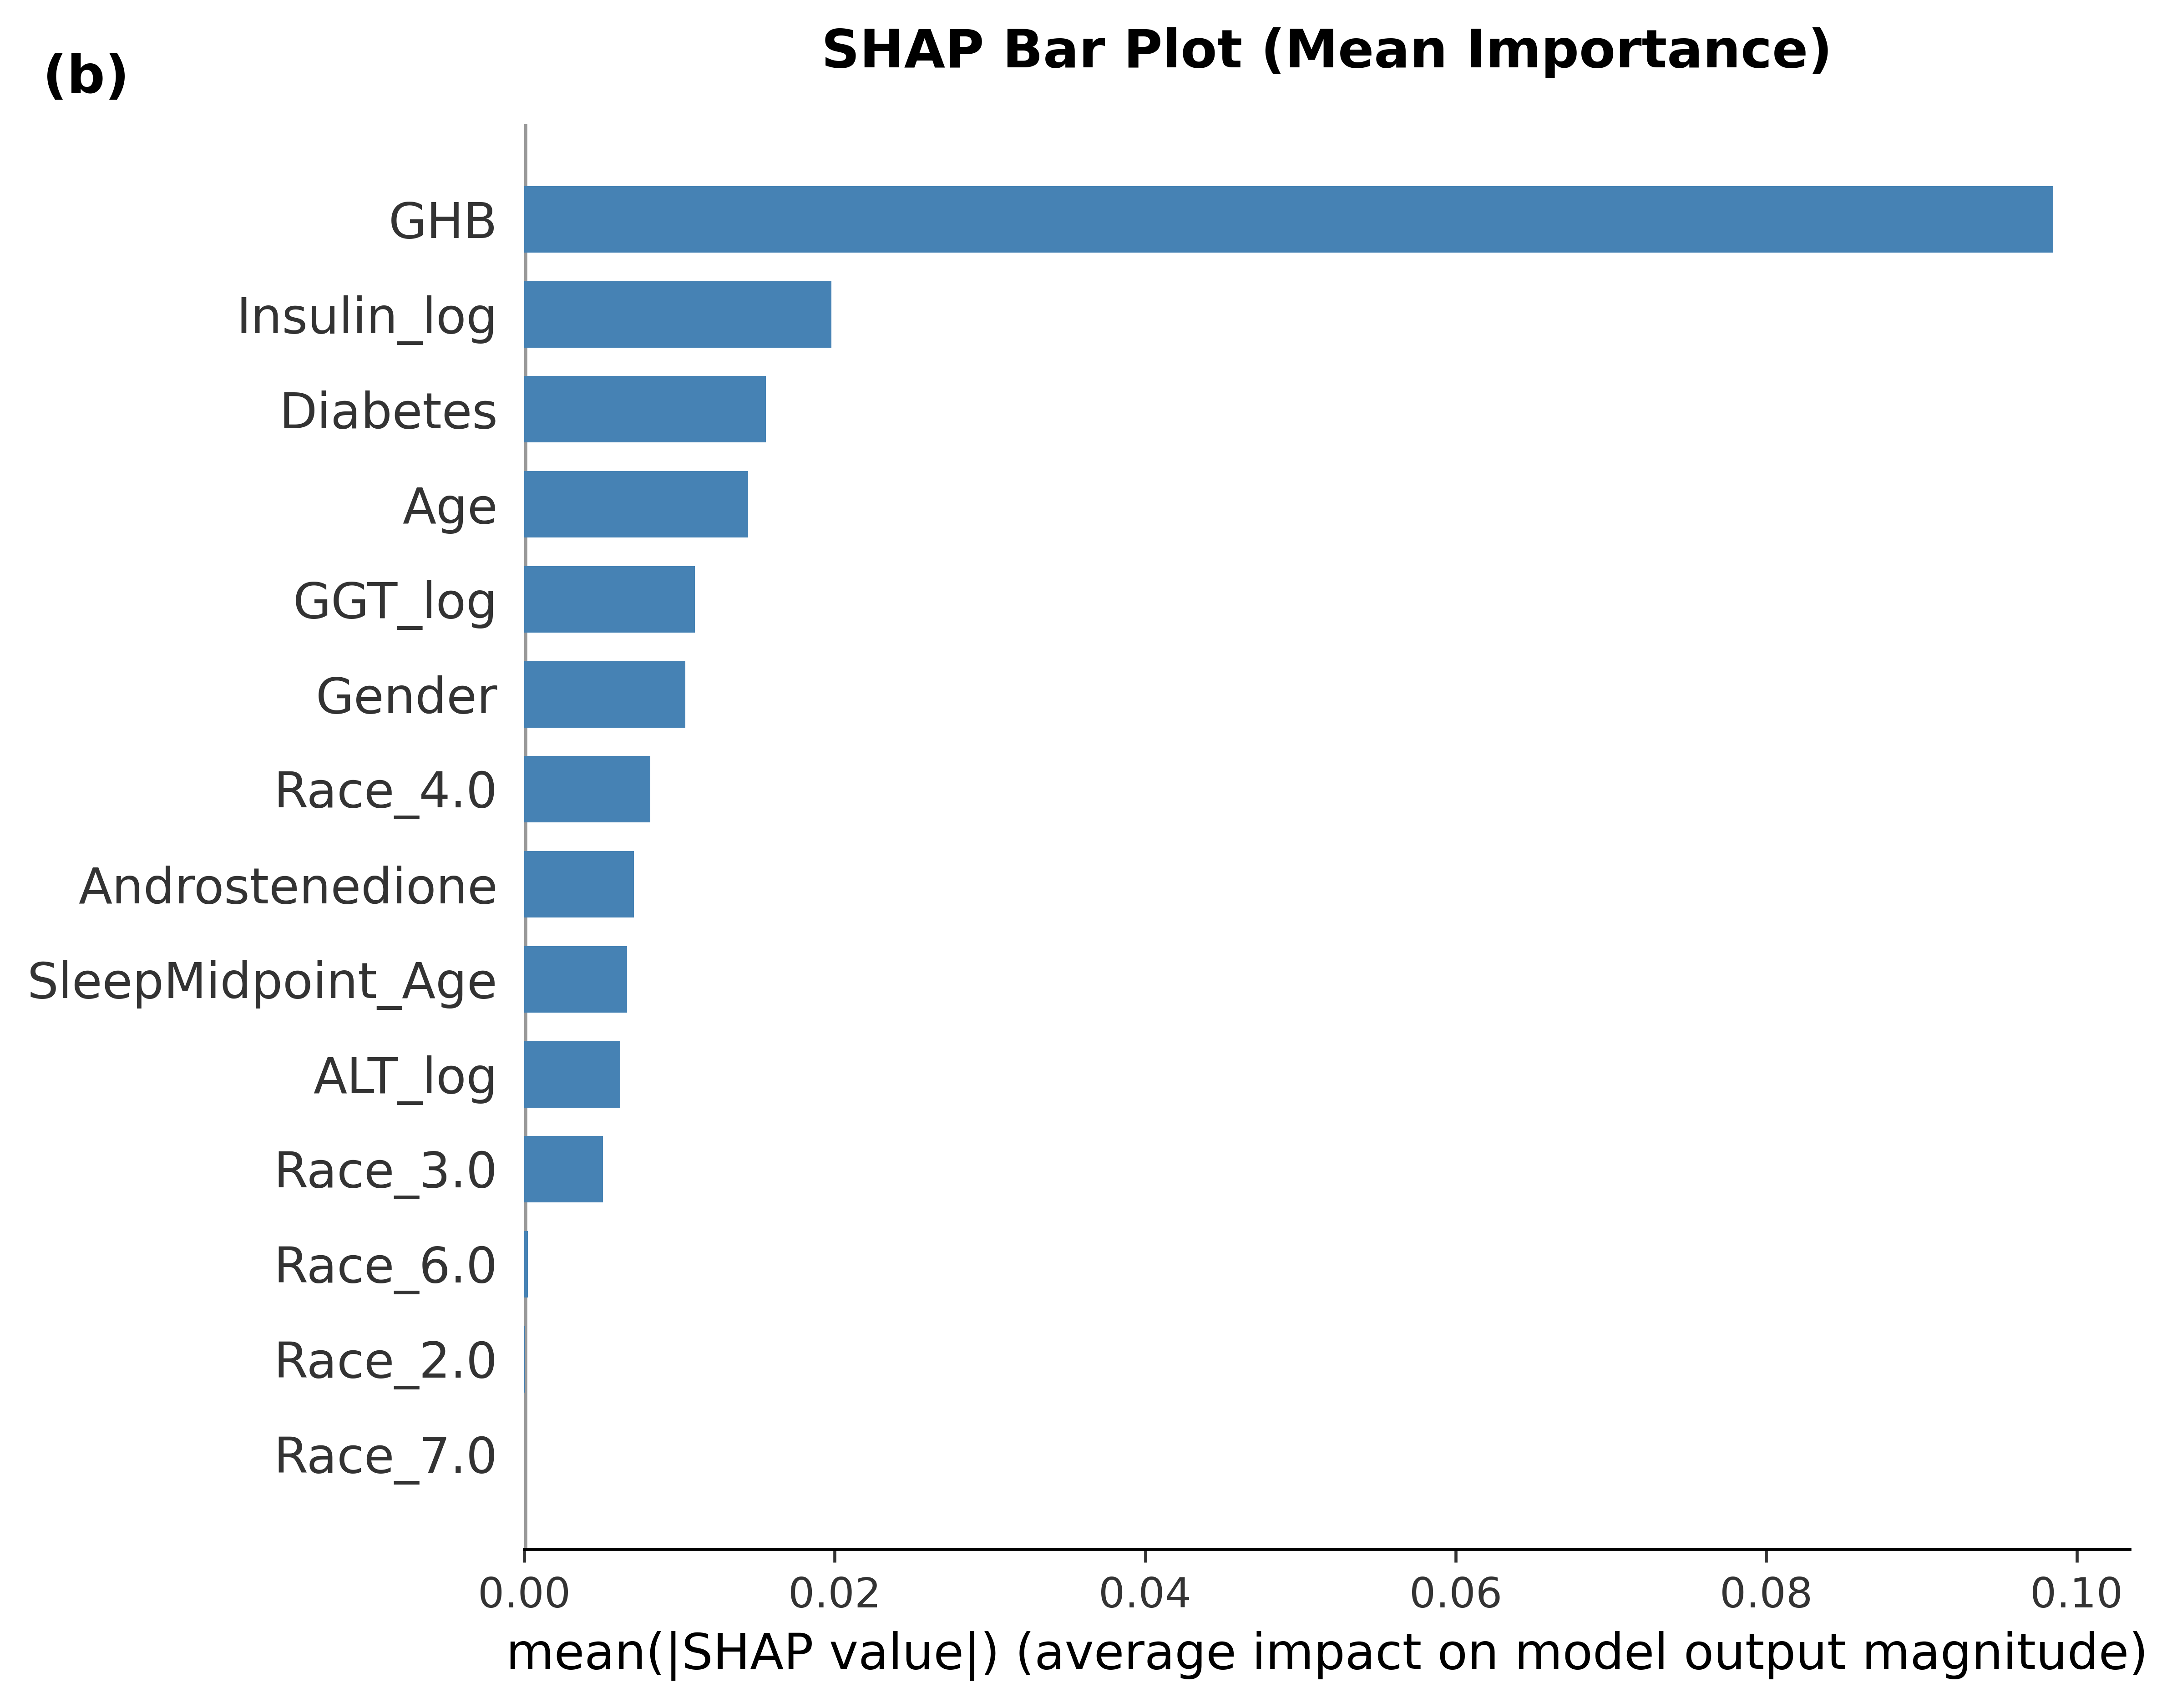

In [91]:
# SHAP Beeswarm Plot
plt.figure(figsize=(8, 6), dpi=600)

shap.summary_plot(
    shap_values_top,
    X_test_top_trans,
    feature_names=feature_names_top_cleaned,
    plot_size=(8, 6),
    color_bar=True,
    show=False
)

# Add figure panel label
plt.text(-0.4, 1.05, '(a)', transform=plt.gca().transAxes,
         fontsize=14, fontweight='bold', va='top', ha='left')

plt.title('SHAP Beeswarm Plot', fontsize=14, pad=15, weight='semibold')

# Save plot
plt.savefig('SHAP_selected_interactions_model_1_v4.png', dpi=600, bbox_inches='tight')
plt.show()

# SHAP Bar Plot
plt.figure(figsize=(8, 6), dpi=600)

shap.summary_plot(
    shap_values_top,
    X_test_top_trans,
    feature_names=feature_names_top_cleaned,
    plot_type='bar',
    color='steelblue',
    show=False,
    plot_size=(8, 6)
)

# Add figure panel label
plt.text(-0.3, 1.05, '(b)', transform=plt.gca().transAxes,
         fontsize=14, fontweight='bold', va='top', ha='left')

plt.title('SHAP Bar Plot (Mean Importance)', fontsize=14, pad=15, weight='semibold')

# Save plot
plt.savefig('SHAP_selected_interactions_model_2_v4.png', dpi=600, bbox_inches='tight')
plt.show()


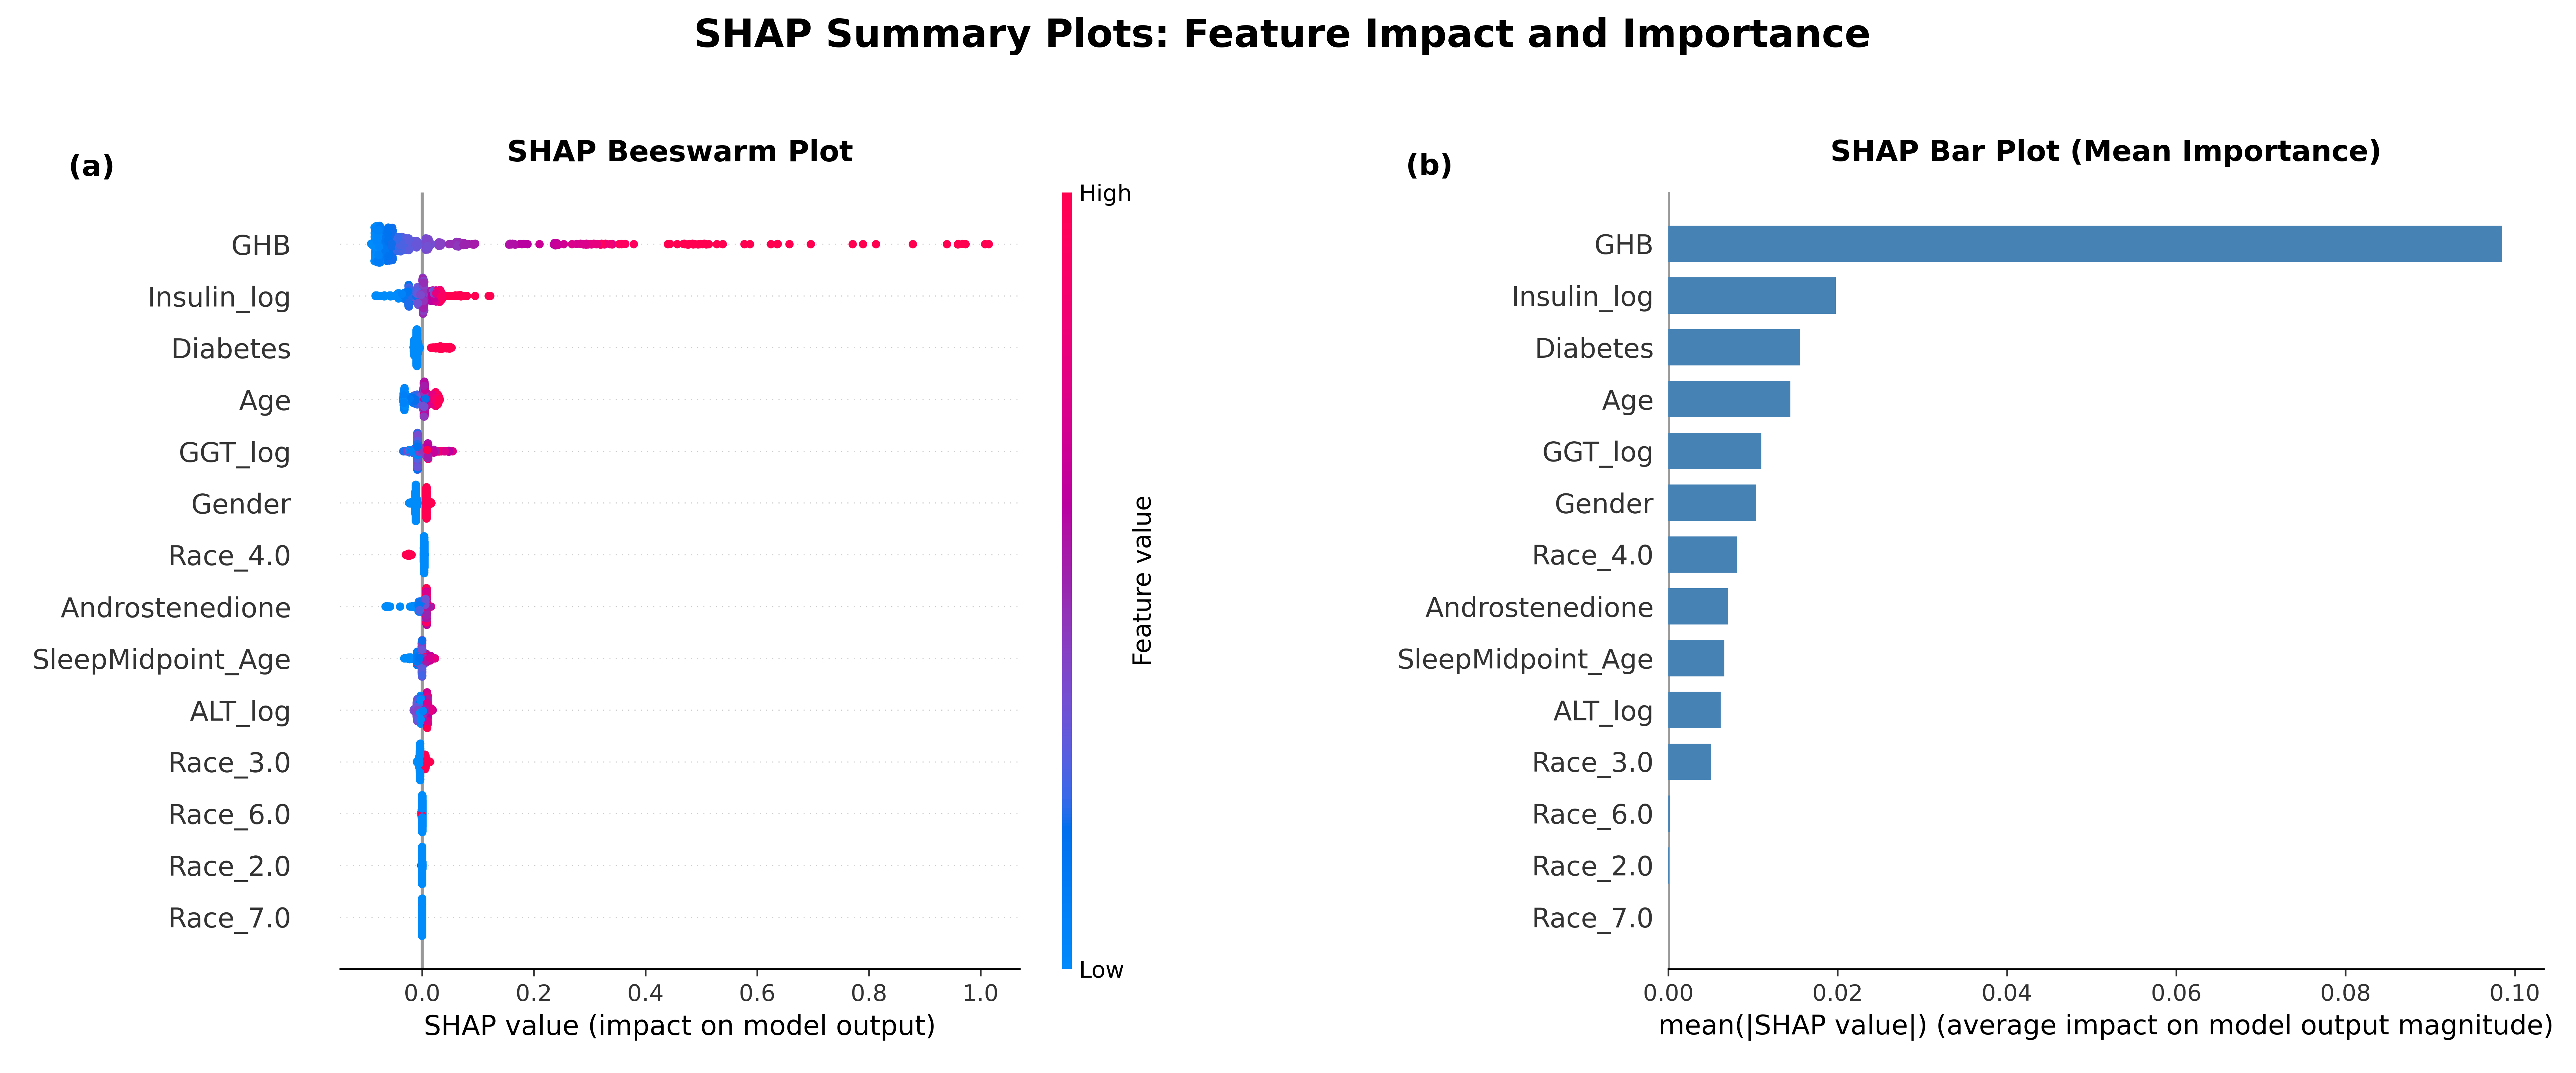

In [97]:
import matplotlib.image as mpimg

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=600)

# Load and plot each image
for i, ax in enumerate(axes):
    img = mpimg.imread(f'SHAP_selected_interactions_model_{i+1}_v4.png')
    ax.imshow(img)
    ax.axis('off') 

# Add universal title
plt.suptitle('SHAP Summary Plots: Feature Impact and Importance', 
             fontsize=16, weight='semibold', y=1.02) 

# Tight layout and save
plt.tight_layout(pad=1)
plt.savefig('SHAP_combined_horizontal_with_title.png', dpi=600, bbox_inches='tight')
plt.show()


In [98]:
np.abs(shap_values_top.values).mean(axis=0)


array([6.19871903e-03, 6.63038253e-03, 1.09878117e-02, 9.84893683e-02,
       1.97769672e-02, 7.05791961e-03, 1.44196871e-02, 5.58780768e-05,
       5.07053320e-03, 8.11514002e-03, 2.31816824e-04, 0.00000000e+00,
       1.55538941e-02, 1.03893304e-02])

In [99]:
feature_names_top_cleaned

['ALT_log',
 'SleepMidpoint_Age',
 'GGT_log',
 'GHB',
 'Insulin_log',
 'Androstenedione',
 'Age',
 'Race_2.0',
 'Race_3.0',
 'Race_4.0',
 'Race_6.0',
 'Race_7.0',
 'Diabetes',
 'Gender']

In [78]:
print(table)

+-----------------------------+--------+-------------+------------+-----------------------+-----------------+----------+
|            Model            |  MAE   | R^2 (Train) | R^2 (Test) | R^2 (Cross-validated) | R^2 (Nested CV) | Features |
+-----------------------------+--------+-------------+------------+-----------------------+-----------------+----------+
|     1. ElasticNet (Full)    | 0.0883 |    0.679    |   0.7433   |     0.672 ± 0.037     |      0.672      |    85    |
|      2. XGBoost (Full)      | 0.0801 |    0.7821   |   0.7808   |     0.700 ± 0.041     |      0.7012     |    85    |
|    3. XGBoost (Selected)    | 0.0816 |    0.7628   |   0.7619   |     0.707 ± 0.035     |      0.7073     |    10    |
| 4. XGBoost (+ Interactions) | 0.0803 |    0.8069   |   0.7744   |     0.697 ± 0.042     |      0.6979     |    90    |
|      5. XGBoost (Final)     | 0.0812 |    0.7694   |   0.7648   |     0.708 ± 0.038     |      0.7077     |    12    |
|     5-1. XGBoost (Final)    | 

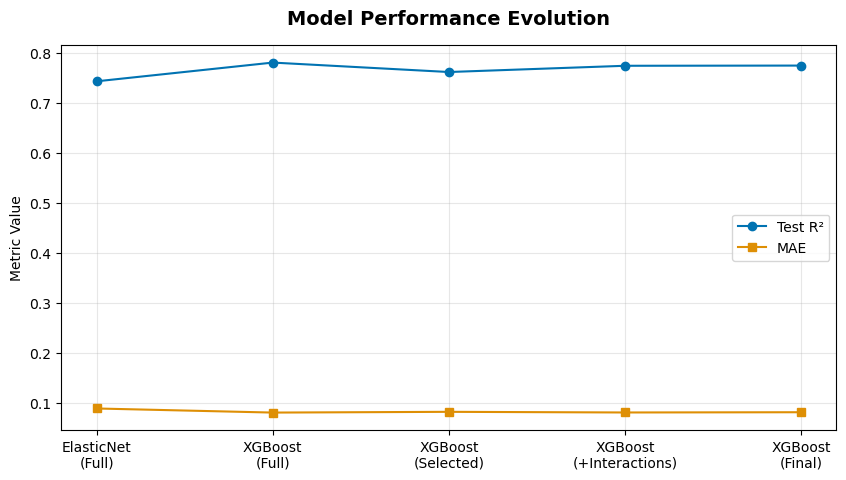

In [79]:
# Create performance evolution plot
plt.figure(figsize=(10,5))
plt.plot([1,2,3,4,5], [0.7433, 0.7808, 0.7619, 0.7744, 0.7748], 
        marker='o', label='Test R²')
plt.plot([1,2,3,4,5], [0.0883, 0.0801, 0.0816, 0.0803, 0.0808], 
        marker='s', label='MAE')
plt.xticks(ticks=[1,2,3,4,5], 
          labels=['ElasticNet\n(Full)', 'XGBoost\n(Full)', 
                  'XGBoost\n(Selected)', 'XGBoost\n(+Interactions)', 
                  'XGBoost\n(Final)'])
plt.title('Model Performance Evolution', fontsize=14, pad=15, weight='semibold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('model_performance_evolution_v2_1.png', dpi=300, bbox_inches='tight')
plt.show()

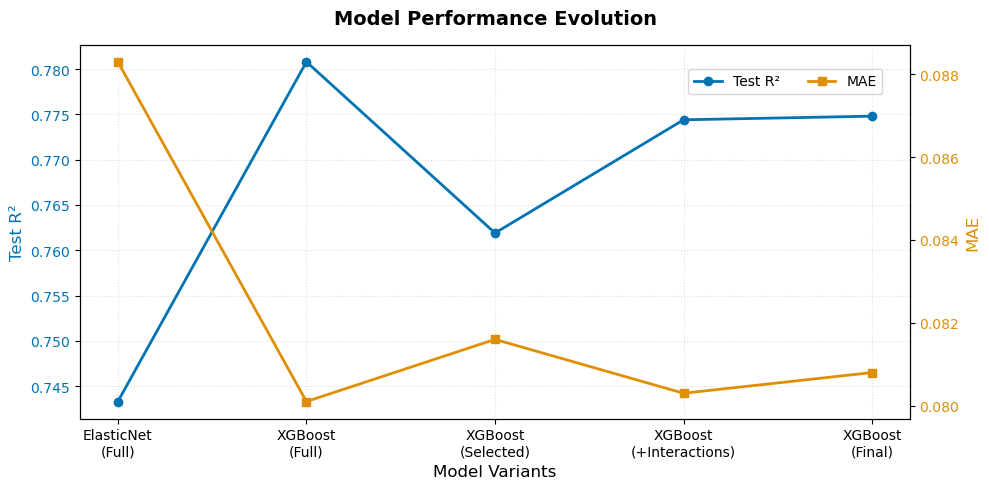

In [81]:
# Colorblind-friendly palette
colors = sns.color_palette("colorblind")

# Model Labels
model_labels = ['ElasticNet\n(Full)', 'XGBoost\n(Full)', 
                'XGBoost\n(Selected)', 'XGBoost\n(+Interactions)', 
                'XGBoost\n(Final)']

# Performance values
r2_test = [0.7433, 0.7808, 0.7619, 0.7744, 0.7748]
mae_vals = [0.0883, 0.0801, 0.0816, 0.0803, 0.0808]

x = range(1, 6)

# Create figure and twin y-axis
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot R²
ax1.plot(x, r2_test, marker='o', color=colors[0], label='Test R²', linewidth=2)

# Plot MAE
ax2.plot(x, mae_vals, marker='s', color=colors[1], label='MAE', linewidth=2)

# Axes labels and title
ax1.set_ylabel('Test R²', color=colors[0], fontsize=12)
ax2.set_ylabel('MAE', color=colors[1], fontsize=12)
ax1.set_xlabel('Model Variants', fontsize=12)
plt.title('Model Performance Evolution', fontsize=14, pad=15, weight='semibold')

# Ticks
ax1.set_xticks(x)
ax1.set_xticklabels(model_labels, fontsize=10)

ax1.tick_params(axis='y', labelcolor=colors[0])
ax2.tick_params(axis='y', labelcolor=colors[1])

# Grids and layout
ax1.grid(True, linestyle=':', alpha=0.4)
fig.tight_layout()

# Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', ncol=2, bbox_to_anchor=(0.85, 0.85))

# Save figure
plt.savefig('model_performance_evolution_v4.png', dpi=600, bbox_inches='tight')
plt.show()


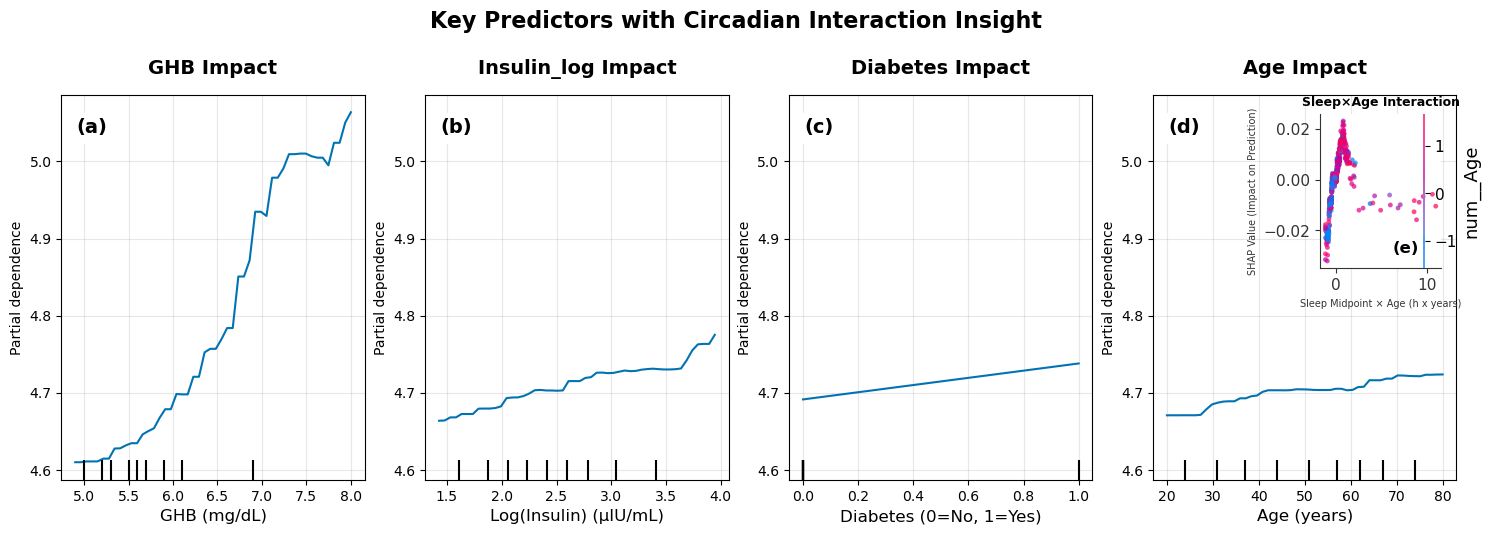

In [82]:
from sklearn.inspection import PartialDependenceDisplay

# Define top features for PDP
main_features = ['GHB', 'Insulin_log', 'Diabetes', 'Age']
sleep_feature = 'num__SleepMidpoint_Age'

# Create figure with 3 subplots 
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Generate main PDPs
pdp_display = PartialDependenceDisplay.from_estimator(
    best_model_top, 
    X_train_val[top_features], 
    features=main_features,
    grid_resolution=50,
    kind='average',
    ax=axes
)

# SHAP interaction inset plot
# Create DataFrame from transformed test data
X_test_top_df = pd.DataFrame(X_test_top_trans, columns=feature_names_top)

# Feature indices for SHAP dependence plot
sleep_idx = X_test_top_df.columns.get_loc(sleep_feature)
age_idx = X_test_top_df.columns.get_loc('num__Age')

# Inset axis
axins = axes[3].inset_axes([0.55, 0.55, 0.4, 0.4])

# SHAP dependence with interaction
shap.dependence_plot(
    sleep_idx,  
    shap_values_top.values,
    X_test_top_df,
    feature_names=X_test_top_df.columns.tolist(),
    interaction_index=age_idx,
    ax=axins,
    show=False,
    dot_size=12,
    alpha=0.7
)

# Customize PDP subplots
# Customize PDP subplots
for i, ax in enumerate(axes):
    name = main_features[i]
    if name == 'Age':
        xlabel = 'Age (years)'
    elif name == 'GHB':
        xlabel = 'GHB (mg/dL)'
    elif name == 'Insulin_log':
        xlabel = 'Log(Insulin) (μIU/mL)'
    elif name == 'Diabetes':
        xlabel = 'Diabetes (0=No, 1=Yes)'
    else:
        xlabel = f'{name} Level'

    clean_name = name.split('__')[-1]
    ax.set_title(f'{clean_name} Impact', fontsize=14, pad=15, weight='semibold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.grid(alpha=0.3)


# Customize inset plot
axins.set_title('Sleep×Age Interaction', fontsize=9, weight='semibold')
axins.set_xlabel('Sleep Midpoint × Age (h x years)', fontsize=7)
axins.set_ylabel('SHAP Value (Impact on Prediction)', fontsize=7)

# Label main plots (a-d)
for i, ax in enumerate(axes):
    ax.annotate(f'({chr(97+i)})',  # 97 = ASCII for 'a'
                xy=(0.05, 0.9), 
                xycoords='axes fraction',
                fontsize=14, weight='bold',
                backgroundcolor='white')

# Label inset plot
axins.annotate('(e)', 
              xy=(0.60, 0.10), 
              xycoords='axes fraction',
              fontsize=12, weight='bold',
              backgroundcolor='white')

# Final titles and saving
plt.suptitle('Key Predictors with Circadian Interaction Insight',
             y=1.05, fontsize=16, weight='semibold')
#plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.savefig('PDP_labeled_v4.png', dpi=600, bbox_inches='tight')
plt.show()

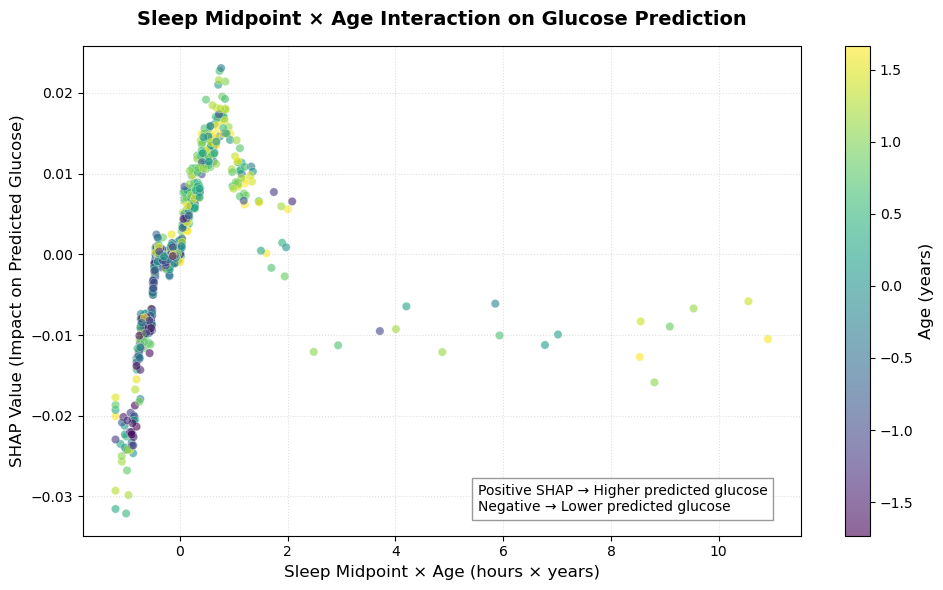

In [83]:
plt.figure(figsize=(10, 6))

# Get feature values and SHAP values
X_test_top_df = pd.DataFrame(X_test_top_trans, columns=feature_names_top)
feature_values = X_test_top_df['num__SleepMidpoint_Age']
shap_vals = shap_values_top.values[:, feature_names_top.tolist().index('num__SleepMidpoint_Age')]
age_values = X_test_top_df['num__Age']

# Create scatter plot
scatter = plt.scatter(
    feature_values,
    shap_vals,
    c=age_values,
    cmap='viridis',  
    alpha=0.6,
    edgecolors='w',
    linewidth=0.3
)

# Colorbar with units
cbar = plt.colorbar(scatter)
cbar.set_label('Age (years)', fontsize=12)

# Add labels and improved axis titles
plt.title('Sleep Midpoint × Age Interaction on Glucose Prediction', fontsize=14, pad=15, weight='semibold')
plt.xlabel('Sleep Midpoint × Age (hours × years)', fontsize=12)
plt.ylabel('SHAP Value (Impact on Predicted Glucose)', fontsize=12)

# Add grid
plt.grid(True, linestyle=':', alpha=0.4)

# Interpretive note
plt.text(
    0.55, 0.05,
    'Positive SHAP → Higher predicted glucose\nNegative → Lower predicted glucose',
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)

# Layout and save
plt.tight_layout()
plt.savefig('sleep_age_interaction_v4.png', dpi=600, bbox_inches='tight') 
plt.show()


In [88]:
# Combine X_test and y_test for sorting
X_test_labeled = X_test.copy()
X_test_labeled['y_true'] = y_test

# Sort by glucose level
X_test_sorted = X_test_labeled.sort_values('y_true')

# Pick three meaningful examples
lowest = X_test_sorted.iloc[1]       # Lowest glucose
median = X_test_sorted.iloc[len(X_test_sorted)//2]  # Median glucose
highest = X_test_sorted.iloc[-2]     # Highest glucose

# Get their indices
candidates_idx = [lowest.name, median.name, highest.name]
candidates_pos = [X_test.index.get_loc(i) for i in candidates_idx] 
candidates_pos

[277, 300, 468]

In [89]:
for i, pos in enumerate(candidates_pos):
    plt.figure(figsize=(8, 4), dpi=600) 
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values_top[pos],
            base_values=explainer_top.expected_value,
            data=X_test[top_features].iloc[pos],
            feature_names=feature_names_top_cleaned
        ),
        max_display=10,
        show=False
    )       
    plt.title(f'Example {i+1} : Glucose = {y_test.iloc[pos]:.2f} mg/dL', fontsize=12, pad=10, weight='semibold')
    if i == 0:
        plt.suptitle('Individual-Level SHAP Waterfall Plots (Final Model)', fontsize=14, weight='semibold', y=1.05)
    plt.tight_layout(pad=0.5)  # Reduce padding
    plt.savefig(f'shap_plot_{i}_v4.png', dpi=600, bbox_inches='tight')
    plt.close()

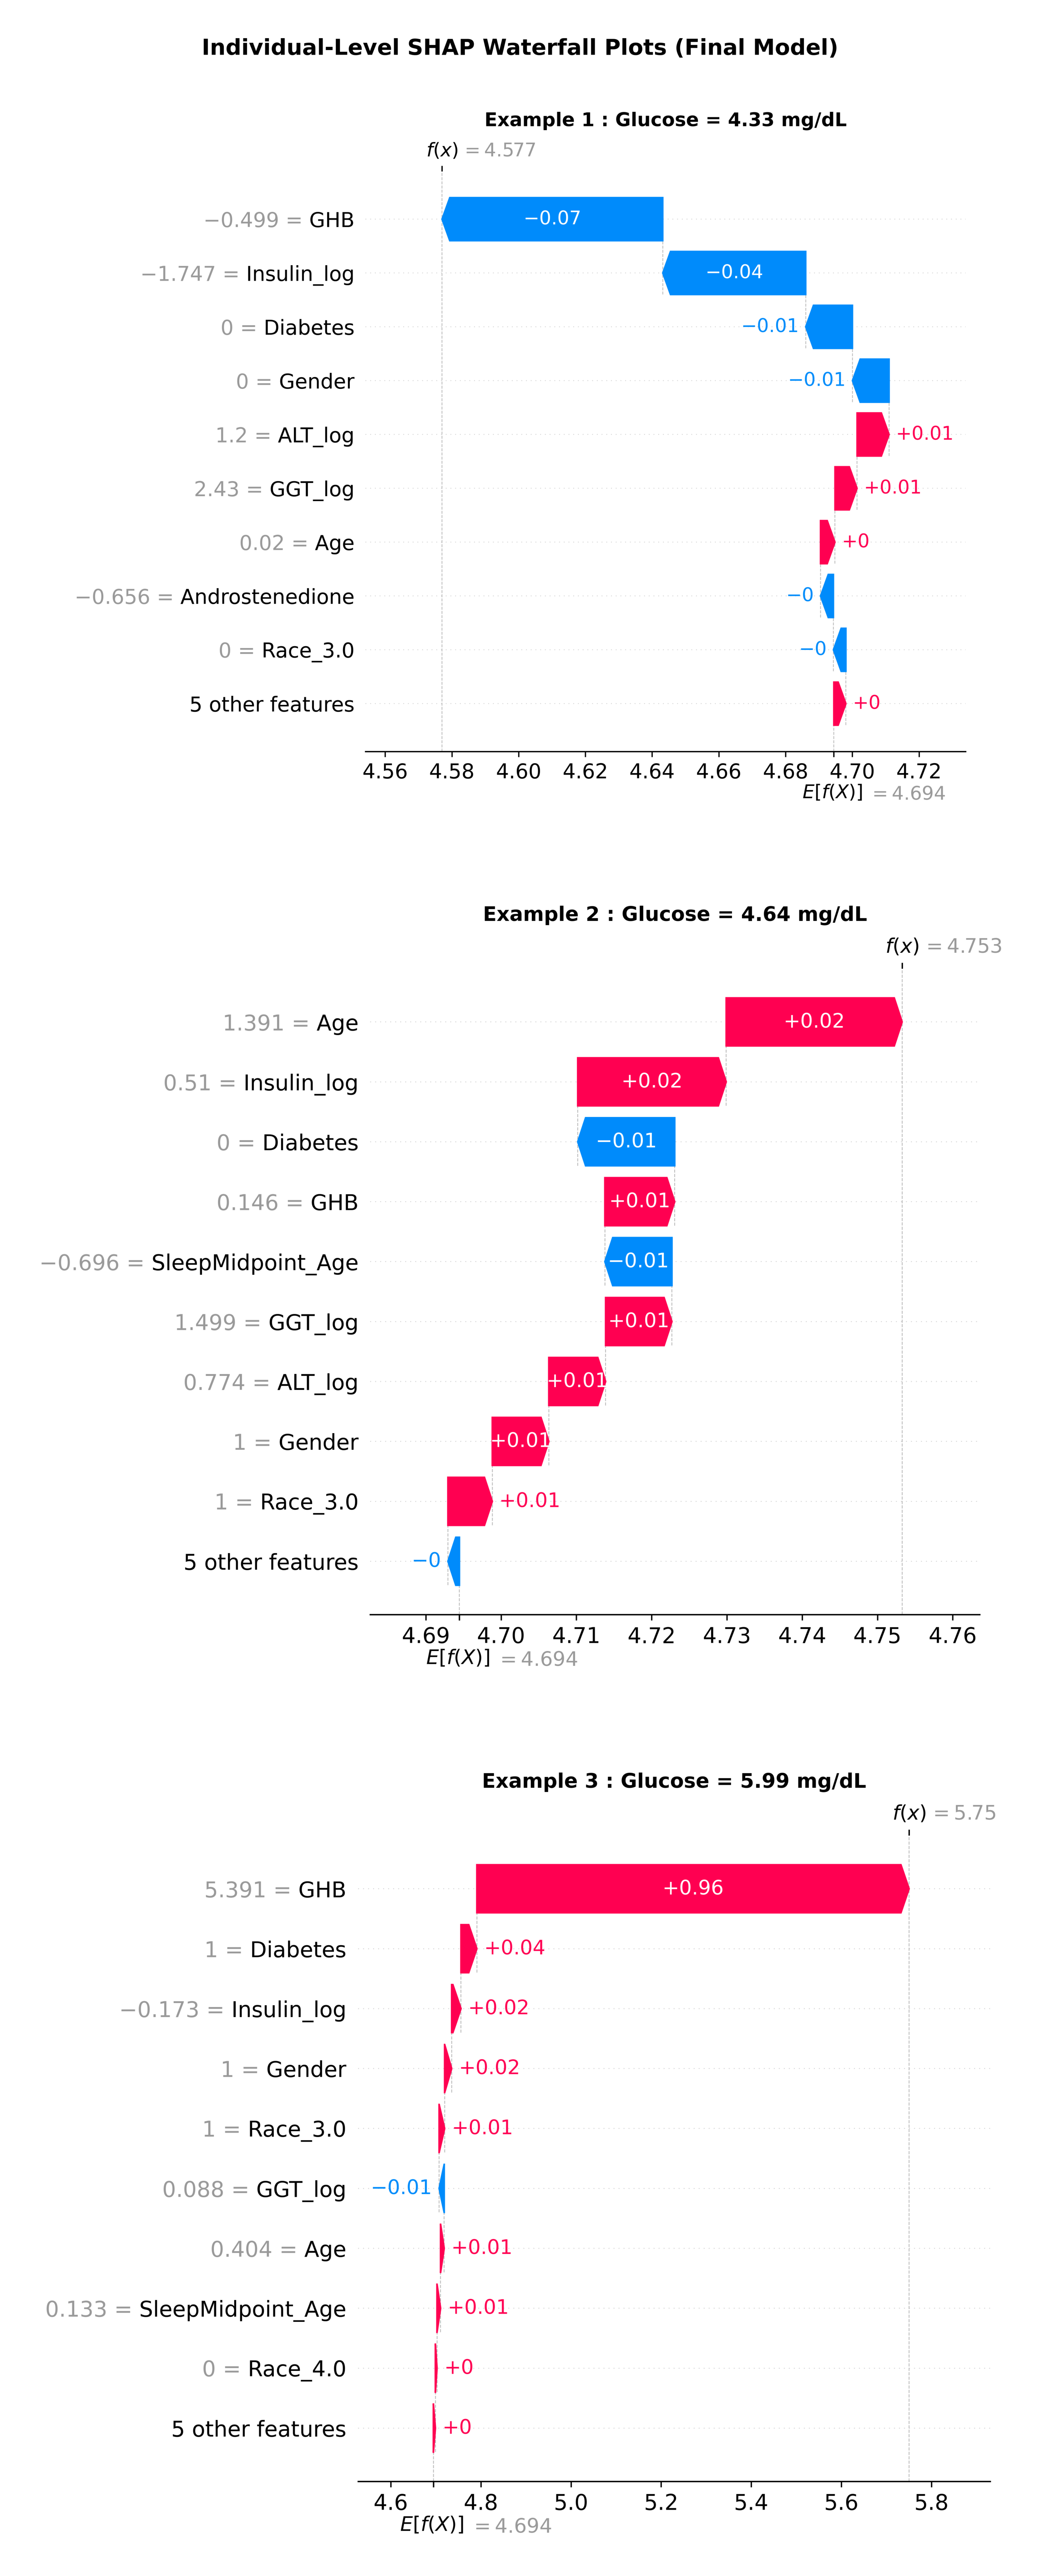

In [95]:
import matplotlib.image as mpimg

fig, axes = plt.subplots(nrows=3, figsize=(8, 12), dpi=600)  

for i in range(3):
    img = mpimg.imread(f'shap_plot_{i}_v4.png')
    axes[i].imshow(img)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.1)  # Minimize vertical gap
plt.savefig('shap_waterfall_v4.png', dpi=600, bbox_inches='tight')
plt.show()